In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5'

VALID_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 20.0
EPOCHS = 100
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [4]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [5]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [6]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = min(pos_images.shape[0], neg_images.shape[0], batch_size)
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Classification Generator 

In [7]:
class RandomBalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen=ImageDataGenerator(), batch_size=1):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        self._shape = x.shape   
        
        self.datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), 
            y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )
        
    def __len__(self):
        return self.steps_per_epoch   
    
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


class DeterministicBalancedGenerator(Sequence):
    def __init__(self, balanced_gen):
        self.x_gen = []
        self.y_gen = []
        self.steps_per_epoch = balanced_gen.steps_per_epoch
        
        for i in range(balanced_gen.steps_per_epoch):
            x, y = balanced_gen.__getitem__(None)
            self.x_gen.append(x)
            self.y_gen.append(y)
        
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        return self.x_gen[idx], self.y_gen[idx]

# Triplet Loss 

In [8]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [9]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    encoder = Model(inputs=autoencoder.inputs, outputs=encoder_output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = Dropout(rate=0.5)(base_model.get_layer(output_name).output)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [10]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)


def train_classification_model(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.log_param("valid_size", VALID_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("file_model", FILE_MODEL)
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=train_gen.steps_per_epoch,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [11]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared


def run_classification_training(model_shared, train_data, valid_data, train_gen, valid_gen, name):
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    
    valid_bal = RandomBalancedDataGenerator(x_valid, y_valid, valid_gen, BATCH_SIZE)
    train_gen_bal = RandomBalancedDataGenerator(x_train, y_train, train_gen, BATCH_SIZE)
    valid_gen_bal = DeterministicBalancedGenerator(valid_bal)
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, train_gen_bal, valid_gen_bal, name)

    x_gen = valid_gen.flow(x_valid, batch_size=len(y_valid), shuffle=False).next()
    y_pred = model_classification.predict(x_gen).flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_valid, y_pred)
    
    return file_model

# Requirements Training 

In [12]:
list_model_files = []

#### 2. Blurred

71 of 71
48 of 48
(94, 160, 160, 3) float32
(94,) int32
(25, 160, 160, 3) float32
(25,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 19s 190ms/step - loss: 15.9371 - val_loss: 22.2303
Epoch 2/100
100/100 [==============================] - 16s 157ms/step - loss: 10.5661 - val_loss: 25.4377
Epoch 3/100
100/100 [==============================] - 16s 157ms/step - loss: 8.1365 - val_loss: 26.8377
Epoch 4/100
100/100 [==============================] - 16s 157ms/step - loss: 6.7068 - val_loss: 27.8335
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: 5.5317 - val_loss: 28.4910
Epoch 6/100
100/100 [==============================] - 16s 157ms/step - loss: 4.3913 - val_loss: 29.2313
Epoch 7/100
100/100 [==============================] - 16s 157ms/step - loss: 3.6472 - val_loss: 29.2510
Epoch 8/100
100/100 [==============================] - 16s 157ms/step - loss: 3.2910 - val_loss: 29.3682
Epoch 9/100
100/100 [==============================] - 16s 157ms/step - loss: 2.5605 - val_loss: 28.5170
Epoch

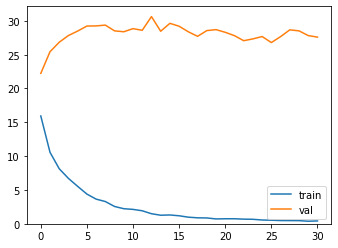

In [13]:
REQ_NAME = 'blurred'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 1s 462ms/step - loss: 0.7979 - accuracy: 0.4688 - precision: 0.4698 - recall: 0.4329 - f1: 0.4475 - specificity: 0.4970 - negative_predictive_value: 0.4536 - matthews_correlation_coefficient: -0.0733 - equal_error_rate: 0.5721 - val_loss: 0.7020 - val_accuracy: 0.4400 - val_precision: 0.4545 - val_recall: 0.3846 - val_f1: 0.4167 - val_specificity: 0.5000 - val_negative_predictive_value: 0.4286 - val_matthews_correlation_coefficient: -0.1161 - val_equal_error_rate: 0.5192

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.11613, saving model to ../../models/siamese_networks/blurred_2020_06_06-23_38_13.h5
Epoch 2/100
3/3 [==============================] - 1s 214ms/step - loss: 0.7124 - accuracy: 0.6375 - precision: 0.6239 - recall: 0.6181 - f1: 0.6184 - specificity: 0.6833 - negative_predictive_value: 0.6802 - matthews_correlation_coefficient: 0.3028 - equal_error_rate: 0.3972 - val_loss: 0.6985 - val_accuracy: 0


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.45760
Epoch 14/100
3/3 [==============================] - 0s 150ms/step - loss: 0.6985 - accuracy: 0.5750 - precision: 0.5307 - recall: 0.5208 - f1: 0.5231 - specificity: 0.6167 - negative_predictive_value: 0.6060 - matthews_correlation_coefficient: 0.1371 - equal_error_rate: 0.4208 - val_loss: 0.6683 - val_accuracy: 0.6800 - val_precision: 0.7778 - val_recall: 0.5385 - val_f1: 0.6364 - val_specificity: 0.8333 - val_negative_predictive_value: 0.6250 - val_matthews_correlation_coefficient: 0.3870 - val_equal_error_rate: 0.1987

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.45760
Epoch 15/100
3/3 [==============================] - 0s 154ms/step - loss: 0.7666 - accuracy: 0.4875 - precision: 0.4479 - recall: 0.4630 - f1: 0.4514 - specificity: 0.4542 - negative_predictive_value: 0.4749 - matthews_correlation_coefficient: -0.0800 - equal_error_rate: 0.5129 - val_loss: 0.6677 - val_accuracy: 

3/3 [==============================] - 0s 143ms/step - loss: 0.6939 - accuracy: 0.5750 - precision: 0.5909 - recall: 0.4421 - f1: 0.5004 - specificity: 0.7214 - negative_predictive_value: 0.5825 - matthews_correlation_coefficient: 0.1684 - equal_error_rate: 0.4101 - val_loss: 0.6634 - val_accuracy: 0.6400 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9167 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.3524 - val_equal_error_rate: 0.2788

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.45760
Epoch 28/100
3/3 [==============================] - 0s 156ms/step - loss: 0.6849 - accuracy: 0.6125 - precision: 0.6071 - recall: 0.6019 - f1: 0.5960 - specificity: 0.6560 - negative_predictive_value: 0.6474 - matthews_correlation_coefficient: 0.2561 - equal_error_rate: 0.3749 - val_loss: 0.6623 - val_accuracy: 0.6400 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9167


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.45760
Epoch 41/100
3/3 [==============================] - 0s 157ms/step - loss: 0.7184 - accuracy: 0.5521 - precision: 0.5801 - recall: 0.5231 - f1: 0.5491 - specificity: 0.5804 - negative_predictive_value: 0.5263 - matthews_correlation_coefficient: 0.1050 - equal_error_rate: 0.4259 - val_loss: 0.6623 - val_accuracy: 0.6400 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9167 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.3524 - val_equal_error_rate: 0.2788

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.45760
Epoch 42/100
3/3 [==============================] - 0s 143ms/step - loss: 0.6657 - accuracy: 0.6750 - precision: 0.6056 - recall: 0.4722 - f1: 0.5249 - specificity: 0.7875 - negative_predictive_value: 0.6571 - matthews_correlation_coefficient: 0.2614 - equal_error_rate: 0.4403 - val_loss: 0.6627 - val_accuracy: 0

3/3 [==============================] - 0s 146ms/step - loss: 0.6820 - accuracy: 0.5750 - precision: 0.5325 - recall: 0.4792 - f1: 0.4995 - specificity: 0.6583 - negative_predictive_value: 0.6032 - matthews_correlation_coefficient: 0.1366 - equal_error_rate: 0.4417 - val_loss: 0.6664 - val_accuracy: 0.6000 - val_precision: 0.8000 - val_recall: 0.3077 - val_f1: 0.4444 - val_specificity: 0.9167 - val_negative_predictive_value: 0.5500 - val_matthews_correlation_coefficient: 0.2802 - val_equal_error_rate: 0.2788

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.45760
Epoch 55/100
3/3 [==============================] - 0s 148ms/step - loss: 0.7299 - accuracy: 0.6000 - precision: 0.5929 - recall: 0.4398 - f1: 0.5037 - specificity: 0.7339 - negative_predictive_value: 0.5929 - matthews_correlation_coefficient: 0.1794 - equal_error_rate: 0.4306 - val_loss: 0.6663 - val_accuracy: 0.6400 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9167

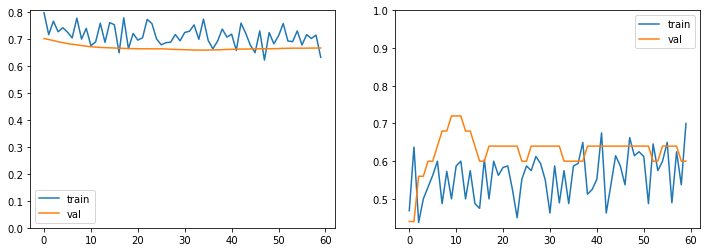

In [14]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 3. Looking Away

146 of 146
159 of 159
(243, 160, 160, 3) float32
(243,) int32
(62, 160, 160, 3) float32
(62,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 242ms/step - loss: 18.2571 - val_loss: 20.7351
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 15.6759 - val_loss: 20.6211
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 13.5827 - val_loss: 21.4869
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 12.0950 - val_loss: 21.7773
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 11.1194 - val_loss: 23.8073
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 10.2756 - val_loss: 22.7487
Epoch 7/100
100/100 [==============================] - 23s 229ms/step - loss: 9.6599 - val_loss: 22.6294
Epoch 8/100
100/100 [==============================] - 23s 229ms/step - loss: 8.5336 - val_loss: 23.2937
Epoch 9/100
100/100 [==============================] - 23s 229ms/step - loss: 8.2277 - val_loss: 22.9343
Epoch 10/100
100/100 [===========================

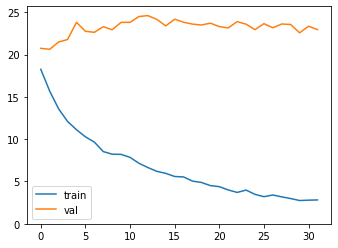

In [15]:
REQ_NAME = 'looking_away'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 2s 265ms/step - loss: 0.7777 - accuracy: 0.5268 - precision: 0.5379 - recall: 0.4578 - f1: 0.4933 - specificity: 0.5893 - negative_predictive_value: 0.5111 - matthews_correlation_coefficient: 0.0480 - equal_error_rate: 0.4771 - val_loss: 0.7546 - val_accuracy: 0.5000 - val_precision: 0.5035 - val_recall: 0.5353 - val_f1: 0.5147 - val_specificity: 0.4725 - val_negative_predictive_value: 0.5045 - val_matthews_correlation_coefficient: 0.0079 - val_equal_error_rate: 0.5147

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00794, saving model to ../../models/siamese_networks/looking_away_2020_06_06-23_51_32.h5
Epoch 2/100
7/7 [==============================] - 1s 151ms/step - loss: 0.8024 - accuracy: 0.4820 - precision: 0.4695 - recall: 0.4225 - f1: 0.4364 - specificity: 0.5499 - negative_predictive_value: 0.5035 - matthews_correlation_coefficient: -0.0273 - equal_error_rate: 0.5148 - val_loss: 0.7500 - val_accuracy

7/7 [==============================] - 1s 158ms/step - loss: 0.7222 - accuracy: 0.5495 - precision: 0.5604 - recall: 0.5296 - f1: 0.5357 - specificity: 0.5788 - negative_predictive_value: 0.5500 - matthews_correlation_coefficient: 0.1094 - equal_error_rate: 0.4195 - val_loss: 0.7266 - val_accuracy: 0.5156 - val_precision: 0.5147 - val_recall: 0.5647 - val_f1: 0.5374 - val_specificity: 0.4686 - val_negative_predictive_value: 0.5190 - val_matthews_correlation_coefficient: 0.0335 - val_equal_error_rate: 0.4539

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.03354
Epoch 15/100
7/7 [==============================] - 1s 162ms/step - loss: 0.7366 - accuracy: 0.5225 - precision: 0.5230 - recall: 0.5733 - f1: 0.5406 - specificity: 0.4814 - negative_predictive_value: 0.5302 - matthews_correlation_coefficient: 0.0539 - equal_error_rate: 0.4850 - val_loss: 0.7265 - val_accuracy: 0.5312 - val_precision: 0.5294 - val_recall: 0.5647 - val_f1: 0.5460 - val_specificity: 0.4980

7/7 [==============================] - 1s 162ms/step - loss: 0.7030 - accuracy: 0.5541 - precision: 0.5447 - recall: 0.5832 - f1: 0.5592 - specificity: 0.5288 - negative_predictive_value: 0.5665 - matthews_correlation_coefficient: 0.1116 - equal_error_rate: 0.4232 - val_loss: 0.7246 - val_accuracy: 0.5469 - val_precision: 0.5432 - val_recall: 0.6235 - val_f1: 0.5798 - val_specificity: 0.4608 - val_negative_predictive_value: 0.5398 - val_matthews_correlation_coefficient: 0.0836 - val_equal_error_rate: 0.4520

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.15171
Epoch 28/100
7/7 [==============================] - 1s 164ms/step - loss: 0.6838 - accuracy: 0.6126 - precision: 0.6128 - recall: 0.6524 - f1: 0.6260 - specificity: 0.5771 - negative_predictive_value: 0.6199 - matthews_correlation_coefficient: 0.2310 - equal_error_rate: 0.3963 - val_loss: 0.7250 - val_accuracy: 0.5469 - val_precision: 0.5432 - val_recall: 0.6235 - val_f1: 0.5798 - val_specificity: 0.4608


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.15171
Epoch 41/100
7/7 [==============================] - 1s 159ms/step - loss: 0.7098 - accuracy: 0.5402 - precision: 0.5510 - recall: 0.6142 - f1: 0.5720 - specificity: 0.4723 - negative_predictive_value: 0.5403 - matthews_correlation_coefficient: 0.0888 - equal_error_rate: 0.4419 - val_loss: 0.7164 - val_accuracy: 0.5156 - val_precision: 0.5167 - val_recall: 0.5608 - val_f1: 0.5369 - val_specificity: 0.4608 - val_negative_predictive_value: 0.5025 - val_matthews_correlation_coefficient: 0.0204 - val_equal_error_rate: 0.4539

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.15171
Epoch 42/100
7/7 [==============================] - 1s 154ms/step - loss: 0.6961 - accuracy: 0.5450 - precision: 0.5340 - recall: 0.4914 - f1: 0.5094 - specificity: 0.5964 - negative_predictive_value: 0.5543 - matthews_correlation_coefficient: 0.0880 - equal_error_rate: 0.4502 - val_loss: 0.7158 - val_accuracy: 0

7/7 [==============================] - 1s 156ms/step - loss: 0.6959 - accuracy: 0.5405 - precision: 0.5430 - recall: 0.5301 - f1: 0.5263 - specificity: 0.5556 - negative_predictive_value: 0.5457 - matthews_correlation_coefficient: 0.0871 - equal_error_rate: 0.4364 - val_loss: 0.7167 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.4980 - val_f1: 0.4985 - val_specificity: 0.4941 - val_negative_predictive_value: 0.4921 - val_matthews_correlation_coefficient: -0.0079 - val_equal_error_rate: 0.4520

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.15171
Epoch 55/100
7/7 [==============================] - 1s 156ms/step - loss: 0.7189 - accuracy: 0.5315 - precision: 0.5244 - recall: 0.4893 - f1: 0.5054 - specificity: 0.5616 - negative_predictive_value: 0.5247 - matthews_correlation_coefficient: 0.0501 - equal_error_rate: 0.4744 - val_loss: 0.7175 - val_accuracy: 0.5156 - val_precision: 0.5192 - val_recall: 0.4980 - val_f1: 0.5071 - val_specificity: 0.523


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.15171
Epoch 68/100
7/7 [==============================] - 1s 154ms/step - loss: 0.6911 - accuracy: 0.5901 - precision: 0.6006 - recall: 0.5985 - f1: 0.5937 - specificity: 0.5862 - negative_predictive_value: 0.5816 - matthews_correlation_coefficient: 0.1834 - equal_error_rate: 0.4194 - val_loss: 0.7217 - val_accuracy: 0.5000 - val_precision: 0.5061 - val_recall: 0.4980 - val_f1: 0.5000 - val_specificity: 0.4902 - val_negative_predictive_value: 0.4818 - val_matthews_correlation_coefficient: -0.0120 - val_equal_error_rate: 0.4686
Restoring model weights from the end of the best epoch

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.15171
Epoch 00068: early stopping

   Final Accuracy:  56.45%
  Final Precision:  54.55%
     Final Recall:  60.00%
  Final F-measure:  57.14%
Final Specificity:  53.12%
        Final NPV:  58.62%
        Final MCC:  13.15%

[[17 15]
 [12 18]]
              precis

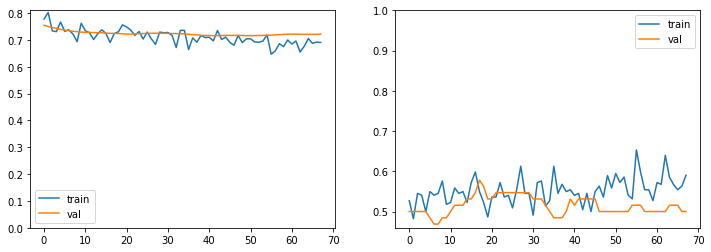

In [16]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)


list_model_files.append(file_model)

#### ~~4. Ink Marked/Creased~~

#### 5. Unnatural Skin Tone 

63 of 63
51 of 51
(90, 160, 160, 3) float32
(90,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 174ms/step - loss: 13.0710 - val_loss: 23.1478
Epoch 2/100
100/100 [==============================] - 16s 162ms/step - loss: 5.6076 - val_loss: 28.7645
Epoch 3/100
100/100 [==============================] - 16s 162ms/step - loss: 3.2447 - val_loss: 29.9859
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 2.5943 - val_loss: 29.4340
Epoch 5/100
100/100 [==============================] - 16s 163ms/step - loss: 1.9411 - val_loss: 30.1840
Epoch 6/100
100/100 [==============================] - 16s 163ms/step - loss: 1.4237 - val_loss: 30.6206
Epoch 7/100
100/100 [==============================] - 16s 163ms/step - loss: 1.0192 - val_loss: 30.7484
Epoch 8/100
100/100 [==============================] - 16s 163ms/step - loss: 1.0387 - val_loss: 30.7694
Epoch 9/100
100/100 [==============================] - 16s 163ms/step - loss: 0.8366 - val_loss: 29.4858
Epoch 10/100
100/100 [==============================] 

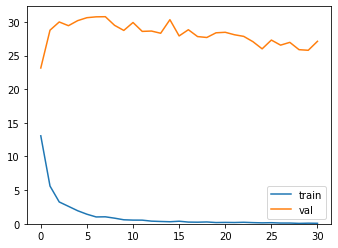

In [17]:
REQ_NAME = 'unnatural_skin_tone'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 1s 483ms/step - loss: 0.8703 - accuracy: 0.5833 - precision: 0.6926 - recall: 0.3109 - f1: 0.4219 - specificity: 0.8593 - negative_predictive_value: 0.5557 - matthews_correlation_coefficient: 0.2045 - equal_error_rate: 0.4378 - val_loss: 1.1198 - val_accuracy: 0.3750 - val_precision: 0.3333 - val_recall: 0.3636 - val_f1: 0.3478 - val_specificity: 0.3846 - val_negative_predictive_value: 0.4167 - val_matthews_correlation_coefficient: -0.2509 - val_equal_error_rate: 0.6259

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.25087, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_07-00_01_41.h5
Epoch 2/100
3/3 [==============================] - 0s 155ms/step - loss: 0.8231 - accuracy: 0.6176 - precision: 0.6667 - recall: 0.1961 - f1: 0.3009 - specificity: 1.0000 - negative_predictive_value: 0.5375 - matthews_correlation_coefficient: 0.2688 - equal_error_rate: 0.4997 - val_loss: 1.0746 - val_

3/3 [==============================] - 0s 143ms/step - loss: 0.5717 - accuracy: 0.7206 - precision: 0.8838 - recall: 0.7059 - f1: 0.7775 - specificity: 0.9111 - negative_predictive_value: 0.7563 - matthews_correlation_coefficient: 0.6283 - equal_error_rate: 0.3121 - val_loss: 0.6969 - val_accuracy: 0.5000 - val_precision: 0.4545 - val_recall: 0.4545 - val_f1: 0.4545 - val_specificity: 0.5385 - val_negative_predictive_value: 0.5385 - val_matthews_correlation_coefficient: -0.0070 - val_equal_error_rate: 0.5420

Epoch 00014: val_matthews_correlation_coefficient improved from -0.09895 to -0.00699, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_07-00_01_41.h5
Epoch 15/100
3/3 [==============================] - 0s 135ms/step - loss: 0.6427 - accuracy: 0.6324 - precision: 0.4286 - recall: 0.3866 - f1: 0.4055 - specificity: 0.8000 - negative_predictive_value: 0.5926 - matthews_correlation_coefficient: 0.1872 - equal_error_rate: 0.3456 - val_loss: 0.6815 - val_accurac

3/3 [==============================] - 0s 150ms/step - loss: 0.6080 - accuracy: 0.6618 - precision: 0.7556 - recall: 0.7311 - f1: 0.7421 - specificity: 0.7889 - negative_predictive_value: 0.7647 - matthews_correlation_coefficient: 0.5201 - equal_error_rate: 0.3437 - val_loss: 0.6088 - val_accuracy: 0.6250 - val_precision: 0.7500 - val_recall: 0.2727 - val_f1: 0.4000 - val_specificity: 0.9231 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.2618 - val_equal_error_rate: 0.4196

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.26179
Epoch 28/100
3/3 [==============================] - 0s 143ms/step - loss: 0.6350 - accuracy: 0.6176 - precision: 0.7333 - recall: 0.5490 - f1: 0.6123 - specificity: 0.7630 - negative_predictive_value: 0.6340 - matthews_correlation_coefficient: 0.3377 - equal_error_rate: 0.3342 - val_loss: 0.6068 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.2727 - val_f1: 0.4286 - val_specificity: 1.0000

3/3 [==============================] - 0s 147ms/step - loss: 0.6820 - accuracy: 0.6029 - precision: 0.7185 - recall: 0.5812 - f1: 0.6181 - specificity: 0.7185 - negative_predictive_value: 0.6368 - matthews_correlation_coefficient: 0.3255 - equal_error_rate: 0.3549 - val_loss: 0.5777 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.2727 - val_f1: 0.4286 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6190 - val_matthews_correlation_coefficient: 0.4109 - val_equal_error_rate: 0.2517

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.41089
Epoch 41/100
3/3 [==============================] - 0s 145ms/step - loss: 0.6312 - accuracy: 0.6250 - precision: 0.6557 - recall: 0.5350 - f1: 0.5873 - specificity: 0.7185 - negative_predictive_value: 0.6062 - matthews_correlation_coefficient: 0.2577 - equal_error_rate: 0.4375 - val_loss: 0.5755 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.2727 - val_f1: 0.4286 - val_specificity: 1.0000

3/3 [==============================] - 0s 156ms/step - loss: 0.5976 - accuracy: 0.6354 - precision: 0.6556 - recall: 0.6218 - f1: 0.6300 - specificity: 0.6481 - negative_predictive_value: 0.6268 - matthews_correlation_coefficient: 0.2761 - equal_error_rate: 0.3650 - val_loss: 0.5587 - val_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.3636 - val_f1: 0.5333 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6500 - val_matthews_correlation_coefficient: 0.4862 - val_equal_error_rate: 0.1678

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.48617
Epoch 54/100
3/3 [==============================] - 0s 132ms/step - loss: 0.5445 - accuracy: 0.7500 - precision: 0.7363 - recall: 0.6176 - f1: 0.6699 - specificity: 0.7444 - negative_predictive_value: 0.6345 - matthews_correlation_coefficient: 0.3664 - equal_error_rate: 0.2493 - val_loss: 0.5579 - val_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.3636 - val_f1: 0.5333 - val_specificity: 1.0000


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.48617
Epoch 67/100
3/3 [==============================] - 0s 148ms/step - loss: 0.5054 - accuracy: 0.7794 - precision: 0.7247 - recall: 0.8655 - f1: 0.7830 - specificity: 0.6778 - negative_predictive_value: 0.8722 - matthews_correlation_coefficient: 0.5681 - equal_error_rate: 0.2291 - val_loss: 0.5497 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.2727 - val_f1: 0.4286 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6190 - val_matthews_correlation_coefficient: 0.4109 - val_equal_error_rate: 0.1678

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.48617
Epoch 68/100
3/3 [==============================] - 0s 138ms/step - loss: 0.6056 - accuracy: 0.6471 - precision: 0.7431 - recall: 0.7437 - f1: 0.7417 - specificity: 0.7593 - negative_predictive_value: 0.7586 - matthews_correlation_coefficient: 0.5023 - equal_error_rate: 0.3128 - val_loss: 0.5493 - val_accuracy: 0

3/3 [==============================] - 0s 151ms/step - loss: 0.6191 - accuracy: 0.6324 - precision: 0.5741 - recall: 0.6359 - f1: 0.6018 - specificity: 0.5556 - negative_predictive_value: 0.6190 - matthews_correlation_coefficient: 0.1923 - equal_error_rate: 0.3128 - val_loss: 0.5330 - val_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.3636 - val_f1: 0.5333 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6500 - val_matthews_correlation_coefficient: 0.4862 - val_equal_error_rate: 0.1678

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.48617
Epoch 81/100
3/3 [==============================] - 0s 156ms/step - loss: 0.6603 - accuracy: 0.6146 - precision: 0.6847 - recall: 0.5588 - f1: 0.6002 - specificity: 0.6889 - negative_predictive_value: 0.5882 - matthews_correlation_coefficient: 0.2599 - equal_error_rate: 0.3234 - val_loss: 0.5315 - val_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.3636 - val_f1: 0.5333 - val_specificity: 1.0000


Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.48617
Epoch 94/100
3/3 [==============================] - 1s 174ms/step - loss: 0.4864 - accuracy: 0.7647 - precision: 0.6827 - recall: 0.7157 - f1: 0.6983 - specificity: 0.6556 - negative_predictive_value: 0.6966 - matthews_correlation_coefficient: 0.3752 - equal_error_rate: 0.1866 - val_loss: 0.5326 - val_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.3636 - val_f1: 0.5333 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6500 - val_matthews_correlation_coefficient: 0.4862 - val_equal_error_rate: 0.1678

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.48617
Epoch 95/100
3/3 [==============================] - 0s 143ms/step - loss: 0.6095 - accuracy: 0.6765 - precision: 0.6627 - recall: 0.7591 - f1: 0.6996 - specificity: 0.6333 - negative_predictive_value: 0.7847 - matthews_correlation_coefficient: 0.4179 - equal_error_rate: 0.3130 - val_loss: 0.5336 - val_accuracy: 0

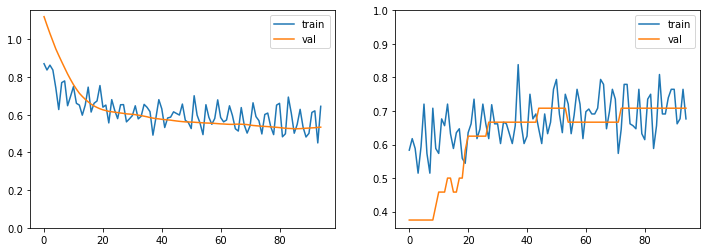

In [18]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 6. Too Dark/Light 

78 of 78
74 of 74
(121, 160, 160, 3) float32
(121,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 190ms/step - loss: 11.8583 - val_loss: 15.8349
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 6.2323 - val_loss: 15.2078
Epoch 3/100
100/100 [==============================] - 18s 176ms/step - loss: 3.8061 - val_loss: 13.8873
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 2.7238 - val_loss: 14.5215
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 1.8607 - val_loss: 13.3266
Epoch 6/100
100/100 [==============================] - 18s 177ms/step - loss: 1.4638 - val_loss: 12.8279
Epoch 7/100
100/100 [==============================] - 18s 177ms/step - loss: 1.1964 - val_loss: 12.6412
Epoch 8/100
100/100 [==============================] - 18s 177ms/step - loss: 0.7912 - val_loss: 14.6738
Epoch 9/100
100/100 [==============================] - 18s 177ms/step - loss: 0.8445 - val_loss: 11.7092
Epoch 10/100
100/100 [==============================] 

100/100 [==============================] - 18s 177ms/step - loss: 0.0142 - val_loss: 10.6501
Epoch 79/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0238 - val_loss: 10.5256
Epoch 80/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0290 - val_loss: 8.1226
Epoch 81/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0153 - val_loss: 8.9116
Epoch 82/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0197 - val_loss: 8.9146
Epoch 83/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0106 - val_loss: 9.2915
Epoch 84/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0145 - val_loss: 9.4352
Epoch 85/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0314 - val_loss: 9.1225
Epoch 86/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0124 - val_loss: 9.6551
Epoch 87/100
100/100 [==============================] - 18s 177ms/

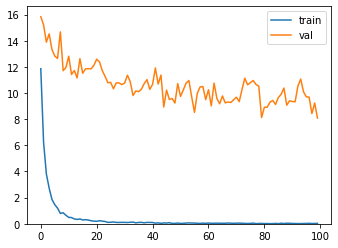

In [19]:
REQ_NAME = 'too_dark_light'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 669ms/step - loss: 1.3437 - accuracy: 0.4167 - precision: 0.4281 - recall: 0.7937 - f1: 0.5558 - specificity: 0.0969 - negative_predictive_value: 0.2889 - matthews_correlation_coefficient: -0.1755 - equal_error_rate: 0.5839 - val_loss: 0.8276 - val_accuracy: 0.4516 - val_precision: 0.4828 - val_recall: 0.8750 - val_f1: 0.6222 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2543 - val_equal_error_rate: 0.4187

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.25427, saving model to ../../models/siamese_networks/too_dark_light_2020_06_07-00_32_34.h5
Epoch 2/100
3/3 [==============================] - 1s 312ms/step - loss: 1.1673 - accuracy: 0.3804 - precision: 0.4392 - recall: 0.6587 - f1: 0.5218 - specificity: 0.0911 - negative_predictive_value: 0.1984 - matthews_correlation_coefficient: -0.3006 - equal_error_rate: 0.5311 - val_loss: 0.7835 -

3/3 [==============================] - 0s 147ms/step - loss: 0.8035 - accuracy: 0.5625 - precision: 0.5256 - recall: 0.4794 - f1: 0.5013 - specificity: 0.6329 - negative_predictive_value: 0.5887 - matthews_correlation_coefficient: 0.1133 - equal_error_rate: 0.4598 - val_loss: 0.6215 - val_accuracy: 0.6452 - val_precision: 0.8571 - val_recall: 0.3750 - val_f1: 0.5217 - val_specificity: 0.9333 - val_negative_predictive_value: 0.5833 - val_matthews_correlation_coefficient: 0.3685 - val_equal_error_rate: 0.2896

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.47708
Epoch 14/100
3/3 [==============================] - 0s 140ms/step - loss: 0.7897 - accuracy: 0.5326 - precision: 0.5606 - recall: 0.4725 - f1: 0.5027 - specificity: 0.5976 - negative_predictive_value: 0.5145 - matthews_correlation_coefficient: 0.0725 - equal_error_rate: 0.4236 - val_loss: 0.6201 - val_accuracy: 0.6452 - val_precision: 0.8571 - val_recall: 0.3750 - val_f1: 0.5217 - val_specificity: 0.9333


Epoch 00026: val_matthews_correlation_coefficient improved from 0.47708 to 0.52291, saving model to ../../models/siamese_networks/too_dark_light_2020_06_07-00_32_34.h5
Epoch 27/100
3/3 [==============================] - 0s 149ms/step - loss: 0.8238 - accuracy: 0.6522 - precision: 0.6752 - recall: 0.6143 - f1: 0.6424 - specificity: 0.6887 - negative_predictive_value: 0.6212 - matthews_correlation_coefficient: 0.2996 - equal_error_rate: 0.3670 - val_loss: 0.5557 - val_accuracy: 0.7097 - val_precision: 1.0000 - val_recall: 0.4375 - val_f1: 0.6087 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6250 - val_matthews_correlation_coefficient: 0.5229 - val_equal_error_rate: 0.1604

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.52291
Epoch 28/100
3/3 [==============================] - 0s 135ms/step - loss: 0.7193 - accuracy: 0.5978 - precision: 0.6500 - recall: 0.5185 - f1: 0.5728 - specificity: 0.6980 - negative_predictive_value: 0.5627 - matthews_correl

3/3 [==============================] - 0s 135ms/step - loss: 0.6625 - accuracy: 0.6304 - precision: 0.7026 - recall: 0.5148 - f1: 0.5927 - specificity: 0.7569 - negative_predictive_value: 0.5805 - matthews_correlation_coefficient: 0.2769 - equal_error_rate: 0.3965 - val_loss: 0.5474 - val_accuracy: 0.7419 - val_precision: 0.9000 - val_recall: 0.5625 - val_f1: 0.6923 - val_specificity: 0.9333 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.5301 - val_equal_error_rate: 0.2250

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.53007
Epoch 41/100
3/3 [==============================] - 0s 147ms/step - loss: 0.7761 - accuracy: 0.5729 - precision: 0.5368 - recall: 0.5048 - f1: 0.5095 - specificity: 0.6351 - negative_predictive_value: 0.6093 - matthews_correlation_coefficient: 0.1428 - equal_error_rate: 0.4288 - val_loss: 0.5499 - val_accuracy: 0.7419 - val_precision: 0.9000 - val_recall: 0.5625 - val_f1: 0.6923 - val_specificity: 0.9333


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.53007
Epoch 54/100
3/3 [==============================] - 0s 130ms/step - loss: 0.5170 - accuracy: 0.7717 - precision: 0.8377 - recall: 0.6804 - f1: 0.7466 - specificity: 0.8856 - negative_predictive_value: 0.7222 - matthews_correlation_coefficient: 0.5626 - equal_error_rate: 0.1916 - val_loss: 0.5522 - val_accuracy: 0.7419 - val_precision: 0.9000 - val_recall: 0.5625 - val_f1: 0.6923 - val_specificity: 0.9333 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.5301 - val_equal_error_rate: 0.2250

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.53007
Epoch 55/100
3/3 [==============================] - 0s 139ms/step - loss: 0.4752 - accuracy: 0.7826 - precision: 0.8477 - recall: 0.6889 - f1: 0.7507 - specificity: 0.8560 - negative_predictive_value: 0.7378 - matthews_correlation_coefficient: 0.5636 - equal_error_rate: 0.2479 - val_loss: 0.5512 - val_accuracy: 0

3/3 [==============================] - 0s 119ms/step - loss: 0.5066 - accuracy: 0.7826 - precision: 0.8690 - recall: 0.6841 - f1: 0.7656 - specificity: 0.8745 - negative_predictive_value: 0.7095 - matthews_correlation_coefficient: 0.5681 - equal_error_rate: 0.2474 - val_loss: 0.5907 - val_accuracy: 0.7419 - val_precision: 0.9000 - val_recall: 0.5625 - val_f1: 0.6923 - val_specificity: 0.9333 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.5301 - val_equal_error_rate: 0.1604

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.53007
Epoch 68/100
3/3 [==============================] - 0s 131ms/step - loss: 0.5185 - accuracy: 0.8043 - precision: 0.8635 - recall: 0.7519 - f1: 0.7999 - specificity: 0.8824 - negative_predictive_value: 0.7549 - matthews_correlation_coefficient: 0.6261 - equal_error_rate: 0.1816 - val_loss: 0.5958 - val_accuracy: 0.7419 - val_precision: 0.9000 - val_recall: 0.5625 - val_f1: 0.6923 - val_specificity: 0.9333


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.53007
Epoch 81/100
3/3 [==============================] - 0s 133ms/step - loss: 0.4092 - accuracy: 0.8438 - precision: 0.8563 - recall: 0.7952 - f1: 0.8224 - specificity: 0.8856 - negative_predictive_value: 0.8386 - matthews_correlation_coefficient: 0.6878 - equal_error_rate: 0.1890 - val_loss: 0.5814 - val_accuracy: 0.7419 - val_precision: 0.9000 - val_recall: 0.5625 - val_f1: 0.6923 - val_specificity: 0.9333 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.5301 - val_equal_error_rate: 0.1604

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.53007
Epoch 82/100
3/3 [==============================] - 0s 131ms/step - loss: 0.4734 - accuracy: 0.7717 - precision: 0.8216 - recall: 0.7402 - f1: 0.7681 - specificity: 0.8109 - negative_predictive_value: 0.7448 - matthews_correlation_coefficient: 0.5581 - equal_error_rate: 0.2033 - val_loss: 0.5824 - val_accuracy: 0

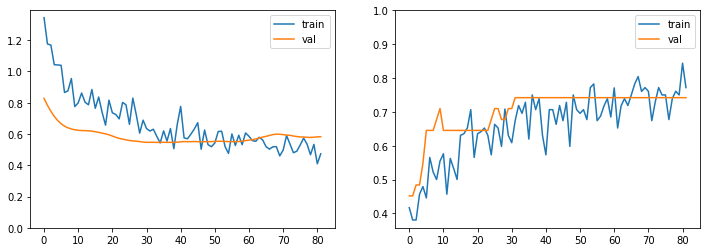

In [20]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 7. Washed Out

79 of 79
43 of 43
(97, 160, 160, 3) float32
(97,) int32
(25, 160, 160, 3) float32
(25,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 169ms/step - loss: 16.4912 - val_loss: 6.8235
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 8.8619 - val_loss: 3.1020
Epoch 3/100
100/100 [==============================] - 16s 156ms/step - loss: 5.7021 - val_loss: 1.0468
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 3.4973 - val_loss: 0.6150
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 2.6609 - val_loss: 0.0000e+00
Epoch 6/100
100/100 [==============================] - 16s 156ms/step - loss: 2.1334 - val_loss: 0.0000e+00
Epoch 7/100
100/100 [==============================] - 16s 156ms/step - loss: 1.6868 - val_loss: 0.0000e+00
Epoch 8/100
100/100 [==============================] - 16s 156ms/step - loss: 1.3390 - val_loss: 0.0000e+00
Epoch 9/100
100/100 [==============================] - 16s 156ms/step - loss: 1.1630 - val_loss: 0.0000e+00
Epoch 10/100
100/100 [=====================

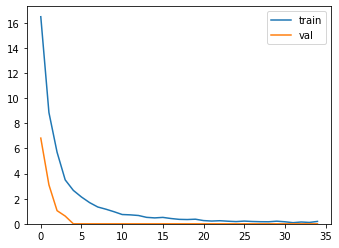

In [21]:
REQ_NAME = 'washed_out'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 505ms/step - loss: 0.7115 - accuracy: 0.6458 - precision: 0.7750 - recall: 0.4338 - f1: 0.5559 - specificity: 0.8744 - negative_predictive_value: 0.5871 - matthews_correlation_coefficient: 0.3339 - equal_error_rate: 0.3853 - val_loss: 0.6394 - val_accuracy: 0.6800 - val_precision: 0.8000 - val_recall: 0.5714 - val_f1: 0.6667 - val_specificity: 0.8182 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.3948 - val_equal_error_rate: 0.3961

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39477, saving model to ../../models/siamese_networks/washed_out_2020_06_07-00_42_57.h5
Epoch 2/100
3/3 [==============================] - 0s 142ms/step - loss: 0.8618 - accuracy: 0.5638 - precision: 0.6083 - recall: 0.3075 - f1: 0.4012 - specificity: 0.8098 - negative_predictive_value: 0.5510 - matthews_correlation_coefficient: 0.1360 - equal_error_rate: 0.4150 - val_loss: 0.6295 - val_accuracy: 0

3/3 [==============================] - 0s 126ms/step - loss: 0.6295 - accuracy: 0.7128 - precision: 0.8918 - recall: 0.4784 - f1: 0.6222 - specificity: 0.9291 - negative_predictive_value: 0.6465 - matthews_correlation_coefficient: 0.4675 - equal_error_rate: 0.2430 - val_loss: 0.5116 - val_accuracy: 0.7600 - val_precision: 1.0000 - val_recall: 0.5714 - val_f1: 0.7273 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6471 - val_matthews_correlation_coefficient: 0.6081 - val_equal_error_rate: 0.1169

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.60807
Epoch 15/100
3/3 [==============================] - 0s 127ms/step - loss: 0.7340 - accuracy: 0.6170 - precision: 0.8380 - recall: 0.3470 - f1: 0.4762 - specificity: 0.9155 - negative_predictive_value: 0.5646 - matthews_correlation_coefficient: 0.3214 - equal_error_rate: 0.3483 - val_loss: 0.5055 - val_accuracy: 0.7600 - val_precision: 1.0000 - val_recall: 0.5714 - val_f1: 0.7273 - val_specificity: 1.0000

3/3 [==============================] - 0s 122ms/step - loss: 0.6120 - accuracy: 0.7340 - precision: 1.0000 - recall: 0.5125 - f1: 0.6635 - specificity: 1.0000 - negative_predictive_value: 0.6539 - matthews_correlation_coefficient: 0.5779 - equal_error_rate: 0.2221 - val_loss: 0.4505 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7857 - val_f1: 0.8800 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7857 - val_matthews_correlation_coefficient: 0.7857 - val_equal_error_rate: 0.1169

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.78571
Epoch 28/100
3/3 [==============================] - 0s 124ms/step - loss: 0.4978 - accuracy: 0.7660 - precision: 0.9667 - recall: 0.5190 - f1: 0.6660 - specificity: 0.9815 - negative_predictive_value: 0.7016 - matthews_correlation_coefficient: 0.5759 - equal_error_rate: 0.2056 - val_loss: 0.4466 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7857 - val_f1: 0.8800 - val_specificity: 1.0000


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.78571
Epoch 41/100
3/3 [==============================] - 0s 137ms/step - loss: 0.5766 - accuracy: 0.6875 - precision: 0.8889 - recall: 0.4639 - f1: 0.6056 - specificity: 0.9407 - negative_predictive_value: 0.6153 - matthews_correlation_coefficient: 0.4517 - equal_error_rate: 0.1968 - val_loss: 0.4085 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7857 - val_f1: 0.8800 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7857 - val_matthews_correlation_coefficient: 0.7857 - val_equal_error_rate: 0.1169

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.78571
Epoch 42/100
3/3 [==============================] - 0s 137ms/step - loss: 0.5183 - accuracy: 0.7340 - precision: 0.8746 - recall: 0.5391 - f1: 0.6635 - specificity: 0.9095 - negative_predictive_value: 0.6711 - matthews_correlation_coefficient: 0.4934 - equal_error_rate: 0.1921 - val_loss: 0.4054 - val_accuracy: 0

3/3 [==============================] - 0s 123ms/step - loss: 0.5354 - accuracy: 0.7128 - precision: 0.8114 - recall: 0.5179 - f1: 0.6310 - specificity: 0.8970 - negative_predictive_value: 0.6602 - matthews_correlation_coefficient: 0.4422 - equal_error_rate: 0.2765 - val_loss: 0.3820 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8571 - val_f1: 0.9231 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8462 - val_matthews_correlation_coefficient: 0.8516 - val_equal_error_rate: 0.1169

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.85163
Epoch 55/100
3/3 [==============================] - 0s 116ms/step - loss: 0.5071 - accuracy: 0.7447 - precision: 0.9722 - recall: 0.5293 - f1: 0.6832 - specificity: 0.9744 - negative_predictive_value: 0.6547 - matthews_correlation_coefficient: 0.5608 - equal_error_rate: 0.1715 - val_loss: 0.3805 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8571 - val_f1: 0.9231 - val_specificity: 1.0000


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.85163
Epoch 68/100
3/3 [==============================] - 0s 129ms/step - loss: 0.4084 - accuracy: 0.8298 - precision: 0.9394 - recall: 0.6743 - f1: 0.7829 - specificity: 0.9630 - negative_predictive_value: 0.7747 - matthews_correlation_coefficient: 0.6740 - equal_error_rate: 0.1716 - val_loss: 0.3610 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8571 - val_f1: 0.9231 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8462 - val_matthews_correlation_coefficient: 0.8516 - val_equal_error_rate: 0.0714

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.85163
Epoch 69/100
3/3 [==============================] - 0s 124ms/step - loss: 0.4081 - accuracy: 0.8438 - precision: 1.0000 - recall: 0.7098 - f1: 0.8267 - specificity: 1.0000 - negative_predictive_value: 0.7552 - matthews_correlation_coefficient: 0.7321 - equal_error_rate: 0.1462 - val_loss: 0.3591 - val_accuracy: 0

3/3 [==============================] - 0s 115ms/step - loss: 0.4275 - accuracy: 0.8333 - precision: 0.9722 - recall: 0.7057 - f1: 0.8170 - specificity: 0.9778 - negative_predictive_value: 0.7471 - matthews_correlation_coefficient: 0.7010 - equal_error_rate: 0.1038 - val_loss: 0.3430 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8571 - val_f1: 0.9231 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8462 - val_matthews_correlation_coefficient: 0.8516 - val_equal_error_rate: 0.0357

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.85163
Epoch 82/100
3/3 [==============================] - 0s 126ms/step - loss: 0.4372 - accuracy: 0.8298 - precision: 0.9333 - recall: 0.6888 - f1: 0.7925 - specificity: 0.9608 - negative_predictive_value: 0.7635 - matthews_correlation_coefficient: 0.6724 - equal_error_rate: 0.1194 - val_loss: 0.3423 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8571 - val_f1: 0.9231 - val_specificity: 1.0000


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.85163
Epoch 95/100
3/3 [==============================] - 0s 122ms/step - loss: 0.3845 - accuracy: 0.8191 - precision: 1.0000 - recall: 0.6671 - f1: 0.7956 - specificity: 1.0000 - negative_predictive_value: 0.7303 - matthews_correlation_coefficient: 0.6980 - equal_error_rate: 0.1046 - val_loss: 0.3287 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8571 - val_f1: 0.9231 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8462 - val_matthews_correlation_coefficient: 0.8516 - val_equal_error_rate: 0.0357

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.85163
Epoch 96/100
3/3 [==============================] - 0s 130ms/step - loss: 0.4225 - accuracy: 0.8085 - precision: 0.9667 - recall: 0.6155 - f1: 0.7509 - specificity: 0.9815 - negative_predictive_value: 0.7424 - matthews_correlation_coefficient: 0.6505 - equal_error_rate: 0.1699 - val_loss: 0.3275 - val_accuracy: 0

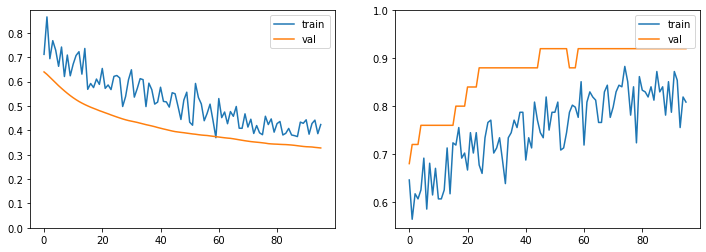

In [22]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 8. Pixelation

79 of 79
105 of 105
(147, 160, 160, 3) float32
(147,) int32
(37, 160, 160, 3) float32
(37,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 192ms/step - loss: 17.1452 - val_loss: 20.4286
Epoch 2/100
100/100 [==============================] - 18s 180ms/step - loss: 13.6531 - val_loss: 19.8094
Epoch 3/100
100/100 [==============================] - 18s 180ms/step - loss: 12.2463 - val_loss: 20.3656
Epoch 4/100
100/100 [==============================] - 18s 180ms/step - loss: 10.9094 - val_loss: 19.9340
Epoch 5/100
100/100 [==============================] - 18s 180ms/step - loss: 9.7399 - val_loss: 21.0901
Epoch 6/100
100/100 [==============================] - 18s 180ms/step - loss: 9.3495 - val_loss: 22.4322
Epoch 7/100
100/100 [==============================] - 18s 180ms/step - loss: 8.7547 - val_loss: 22.8652
Epoch 8/100
100/100 [==============================] - 18s 181ms/step - loss: 7.8677 - val_loss: 22.9321
Epoch 9/100
100/100 [==============================] - 18s 181ms/step - loss: 7.8202 - val_loss: 23.4771
Epoch 10/100
100/100 [=============================

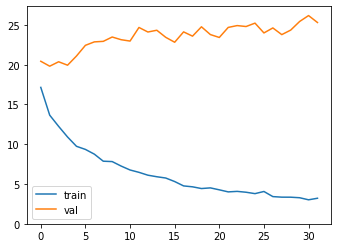

In [23]:
REQ_NAME = 'pixelation'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
5/5 [==============================] - 2s 375ms/step - loss: 0.7517 - accuracy: 0.5125 - precision: 0.5378 - recall: 0.3258 - f1: 0.3969 - specificity: 0.7207 - negative_predictive_value: 0.5097 - matthews_correlation_coefficient: 0.0471 - equal_error_rate: 0.4692 - val_loss: 0.7100 - val_accuracy: 0.5625 - val_precision: 0.6471 - val_recall: 0.5789 - val_f1: 0.6111 - val_specificity: 0.5385 - val_negative_predictive_value: 0.4667 - val_matthews_correlation_coefficient: 0.1156 - val_equal_error_rate: 0.4676

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11555, saving model to ../../models/siamese_networks/pixelation_2020_06_07-00_54_03.h5
Epoch 2/100
5/5 [==============================] - 1s 173ms/step - loss: 0.7293 - accuracy: 0.5809 - precision: 0.4833 - recall: 0.4205 - f1: 0.4419 - specificity: 0.6339 - negative_predictive_value: 0.5669 - matthews_correlation_coefficient: 0.0523 - equal_error_rate: 0.5003 - val_loss: 0.7072 - val_accuracy: 0

5/5 [==============================] - 1s 138ms/step - loss: 0.7587 - accuracy: 0.5000 - precision: 0.4385 - recall: 0.3745 - f1: 0.3902 - specificity: 0.5219 - negative_predictive_value: 0.4268 - matthews_correlation_coefficient: -0.1182 - equal_error_rate: 0.5158 - val_loss: 0.6787 - val_accuracy: 0.5312 - val_precision: 0.6111 - val_recall: 0.5789 - val_f1: 0.5946 - val_specificity: 0.4615 - val_negative_predictive_value: 0.4286 - val_matthews_correlation_coefficient: 0.0401 - val_equal_error_rate: 0.4939

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.11555
Epoch 15/100
5/5 [==============================] - 1s 130ms/step - loss: 0.7946 - accuracy: 0.5074 - precision: 0.4667 - recall: 0.2688 - f1: 0.3373 - specificity: 0.6315 - negative_predictive_value: 0.4568 - matthews_correlation_coefficient: -0.0883 - equal_error_rate: 0.5299 - val_loss: 0.6771 - val_accuracy: 0.5312 - val_precision: 0.6111 - val_recall: 0.5789 - val_f1: 0.5946 - val_specificity: 0.46

5/5 [==============================] - 1s 132ms/step - loss: 0.7861 - accuracy: 0.5221 - precision: 0.4584 - recall: 0.3492 - f1: 0.3902 - specificity: 0.5969 - negative_predictive_value: 0.4945 - matthews_correlation_coefficient: -0.0507 - equal_error_rate: 0.5358 - val_loss: 0.6615 - val_accuracy: 0.5938 - val_precision: 0.6364 - val_recall: 0.7368 - val_f1: 0.6829 - val_specificity: 0.3846 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: 0.1287 - val_equal_error_rate: 0.4939

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.12869
Epoch 28/100
5/5 [==============================] - 1s 134ms/step - loss: 0.7343 - accuracy: 0.5515 - precision: 0.4650 - recall: 0.3660 - f1: 0.4084 - specificity: 0.6537 - negative_predictive_value: 0.5263 - matthews_correlation_coefficient: 0.0061 - equal_error_rate: 0.5467 - val_loss: 0.6609 - val_accuracy: 0.5938 - val_precision: 0.6364 - val_recall: 0.7368 - val_f1: 0.6829 - val_specificity: 0.384

5/5 [==============================] - 1s 138ms/step - loss: 0.7143 - accuracy: 0.5882 - precision: 0.6208 - recall: 0.4409 - f1: 0.4911 - specificity: 0.6852 - negative_predictive_value: 0.5475 - matthews_correlation_coefficient: 0.1451 - equal_error_rate: 0.4826 - val_loss: 0.6505 - val_accuracy: 0.6250 - val_precision: 0.6667 - val_recall: 0.7368 - val_f1: 0.7000 - val_specificity: 0.4615 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.2051 - val_equal_error_rate: 0.4676

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.20514
Epoch 41/100
5/5 [==============================] - 1s 143ms/step - loss: 0.7094 - accuracy: 0.5588 - precision: 0.5589 - recall: 0.4527 - f1: 0.4838 - specificity: 0.6688 - negative_predictive_value: 0.5830 - matthews_correlation_coefficient: 0.1312 - equal_error_rate: 0.4044 - val_loss: 0.6499 - val_accuracy: 0.6250 - val_precision: 0.6667 - val_recall: 0.7368 - val_f1: 0.7000 - val_specificity: 0.4615

5/5 [==============================] - 1s 144ms/step - loss: 0.6709 - accuracy: 0.6176 - precision: 0.5967 - recall: 0.6235 - f1: 0.6014 - specificity: 0.6504 - negative_predictive_value: 0.6882 - matthews_correlation_coefficient: 0.2793 - equal_error_rate: 0.3973 - val_loss: 0.6480 - val_accuracy: 0.6250 - val_precision: 0.6522 - val_recall: 0.7895 - val_f1: 0.7143 - val_specificity: 0.3846 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.1902 - val_equal_error_rate: 0.4676

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.26597
Epoch 54/100
5/5 [==============================] - 1s 147ms/step - loss: 0.7322 - accuracy: 0.5441 - precision: 0.5529 - recall: 0.5363 - f1: 0.5361 - specificity: 0.5800 - negative_predictive_value: 0.5622 - matthews_correlation_coefficient: 0.1156 - equal_error_rate: 0.4327 - val_loss: 0.6477 - val_accuracy: 0.6250 - val_precision: 0.6522 - val_recall: 0.7895 - val_f1: 0.7143 - val_specificity: 0.3846


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.26597
Epoch 67/100
5/5 [==============================] - 1s 141ms/step - loss: 0.6854 - accuracy: 0.5875 - precision: 0.6989 - recall: 0.3987 - f1: 0.4956 - specificity: 0.7715 - negative_predictive_value: 0.5505 - matthews_correlation_coefficient: 0.2046 - equal_error_rate: 0.4172 - val_loss: 0.6443 - val_accuracy: 0.6562 - val_precision: 0.6818 - val_recall: 0.7895 - val_f1: 0.7317 - val_specificity: 0.4615 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.2660 - val_equal_error_rate: 0.4676

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.26597
Epoch 68/100
5/5 [==============================] - 1s 144ms/step - loss: 0.6852 - accuracy: 0.5515 - precision: 0.4933 - recall: 0.4786 - f1: 0.4803 - specificity: 0.5684 - negative_predictive_value: 0.5583 - matthews_correlation_coefficient: 0.0494 - equal_error_rate: 0.4386 - val_loss: 0.6441 - val_accuracy: 0

5/5 [==============================] - 1s 142ms/step - loss: 0.6893 - accuracy: 0.5735 - precision: 0.5488 - recall: 0.5504 - f1: 0.5414 - specificity: 0.6190 - negative_predictive_value: 0.6162 - matthews_correlation_coefficient: 0.1671 - equal_error_rate: 0.3923 - val_loss: 0.6422 - val_accuracy: 0.6562 - val_precision: 0.6818 - val_recall: 0.7895 - val_f1: 0.7317 - val_specificity: 0.4615 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.2660 - val_equal_error_rate: 0.3381

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.26597
Epoch 81/100
5/5 [==============================] - 1s 139ms/step - loss: 0.7071 - accuracy: 0.5441 - precision: 0.5249 - recall: 0.4739 - f1: 0.4922 - specificity: 0.5966 - negative_predictive_value: 0.5446 - matthews_correlation_coefficient: 0.0700 - equal_error_rate: 0.4563 - val_loss: 0.6420 - val_accuracy: 0.6562 - val_precision: 0.6818 - val_recall: 0.7895 - val_f1: 0.7317 - val_specificity: 0.4615


Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.26597
Epoch 94/100
5/5 [==============================] - 1s 136ms/step - loss: 0.7464 - accuracy: 0.4853 - precision: 0.4791 - recall: 0.3334 - f1: 0.3879 - specificity: 0.6401 - negative_predictive_value: 0.4958 - matthews_correlation_coefficient: -0.0258 - equal_error_rate: 0.5248 - val_loss: 0.6411 - val_accuracy: 0.6250 - val_precision: 0.6667 - val_recall: 0.7368 - val_f1: 0.7000 - val_specificity: 0.4615 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.2051 - val_equal_error_rate: 0.2733

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.26597
Epoch 95/100
5/5 [==============================] - 1s 142ms/step - loss: 0.6901 - accuracy: 0.5882 - precision: 0.5993 - recall: 0.5851 - f1: 0.5812 - specificity: 0.6779 - negative_predictive_value: 0.6618 - matthews_correlation_coefficient: 0.2618 - equal_error_rate: 0.4177 - val_loss: 0.6412 - val_accuracy: 

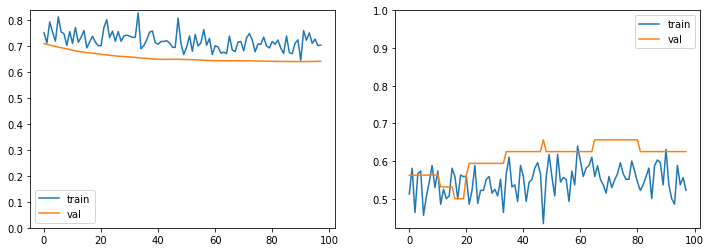

In [24]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 9. Hair Across Eyes 

181 of 181
179 of 179
(287, 160, 160, 3) float32
(287,) int32
(73, 160, 160, 3) float32
(73,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 25s 251ms/step - loss: 15.6006 - val_loss: 17.5897
Epoch 2/100
100/100 [==============================] - 24s 238ms/step - loss: 12.3628 - val_loss: 18.0476
Epoch 3/100
100/100 [==============================] - 24s 238ms/step - loss: 11.2953 - val_loss: 17.4414
Epoch 4/100
100/100 [==============================] - 24s 238ms/step - loss: 9.5714 - val_loss: 19.1048
Epoch 5/100
100/100 [==============================] - 24s 238ms/step - loss: 9.0544 - val_loss: 18.4297
Epoch 6/100
100/100 [==============================] - 24s 238ms/step - loss: 7.8105 - val_loss: 17.3486
Epoch 7/100
100/100 [==============================] - 24s 238ms/step - loss: 7.1967 - val_loss: 17.3774
Epoch 8/100
100/100 [==============================] - 24s 238ms/step - loss: 6.5734 - val_loss: 18.2166
Epoch 9/100
100/100 [==============================] - 24s 238ms/step - loss: 6.0756 - val_loss: 18.0020
Epoch 10/100
100/100 [==============================

100/100 [==============================] - 24s 238ms/step - loss: 0.4614 - val_loss: 15.4640
Epoch 79/100
100/100 [==============================] - 24s 238ms/step - loss: 0.5116 - val_loss: 15.2718
Epoch 80/100
100/100 [==============================] - 24s 238ms/step - loss: 0.4329 - val_loss: 14.8850
Epoch 81/100
100/100 [==============================] - 24s 238ms/step - loss: 0.4895 - val_loss: 14.9954
Epoch 82/100
100/100 [==============================] - 24s 238ms/step - loss: 0.3881 - val_loss: 15.7840
Epoch 83/100
100/100 [==============================] - 24s 239ms/step - loss: 0.3848 - val_loss: 15.0592
Epoch 84/100
100/100 [==============================] - 24s 238ms/step - loss: 0.4415 - val_loss: 15.4907
Epoch 85/100
100/100 [==============================] - 24s 238ms/step - loss: 0.4397 - val_loss: 15.1701
Epoch 86/100
100/100 [==============================] - 24s 238ms/step - loss: 0.3790 - val_loss: 15.0215
Epoch 87/100
100/100 [==============================] - 24s

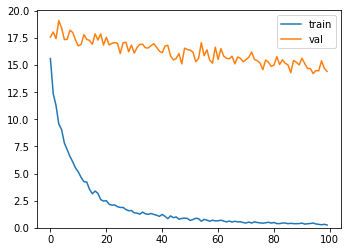

In [25]:
REQ_NAME = 'hair_across_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
9/9 [==============================] - 3s 300ms/step - loss: 0.9302 - accuracy: 0.5069 - precision: 0.5035 - recall: 0.4728 - f1: 0.4815 - specificity: 0.5318 - negative_predictive_value: 0.5007 - matthews_correlation_coefficient: 0.0044 - equal_error_rate: 0.5000 - val_loss: 0.6866 - val_accuracy: 0.5312 - val_precision: 0.5227 - val_recall: 0.3208 - val_f1: 0.3961 - val_specificity: 0.7261 - val_negative_predictive_value: 0.5327 - val_matthews_correlation_coefficient: 0.0510 - val_equal_error_rate: 0.5002

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05098, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_07-01_36_01.h5
Epoch 2/100
9/9 [==============================] - 1s 143ms/step - loss: 0.9547 - accuracy: 0.5069 - precision: 0.5206 - recall: 0.4089 - f1: 0.4462 - specificity: 0.6193 - negative_predictive_value: 0.5115 - matthews_correlation_coefficient: 0.0301 - equal_error_rate: 0.4822 - val_loss: 0.6864 - val_accur


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.29678
Epoch 14/100
9/9 [==============================] - 1s 130ms/step - loss: 0.8080 - accuracy: 0.5347 - precision: 0.5267 - recall: 0.3896 - f1: 0.4439 - specificity: 0.6650 - negative_predictive_value: 0.5260 - matthews_correlation_coefficient: 0.0537 - equal_error_rate: 0.4549 - val_loss: 0.6920 - val_accuracy: 0.6250 - val_precision: 0.8000 - val_recall: 0.2875 - val_f1: 0.4227 - val_specificity: 0.9412 - val_negative_predictive_value: 0.5855 - val_matthews_correlation_coefficient: 0.2968 - val_equal_error_rate: 0.3914

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.29678
Epoch 15/100
9/9 [==============================] - 1s 139ms/step - loss: 0.7660 - accuracy: 0.5625 - precision: 0.5642 - recall: 0.5175 - f1: 0.5298 - specificity: 0.6067 - negative_predictive_value: 0.5609 - matthews_correlation_coefficient: 0.1246 - equal_error_rate: 0.4000 - val_loss: 0.6940 - val_accuracy: 0

9/9 [==============================] - 1s 137ms/step - loss: 0.7442 - accuracy: 0.5660 - precision: 0.5806 - recall: 0.4831 - f1: 0.5210 - specificity: 0.6531 - negative_predictive_value: 0.5580 - matthews_correlation_coefficient: 0.1374 - equal_error_rate: 0.4336 - val_loss: 0.7067 - val_accuracy: 0.6250 - val_precision: 0.8167 - val_recall: 0.2896 - val_f1: 0.4273 - val_specificity: 0.9393 - val_negative_predictive_value: 0.5848 - val_matthews_correlation_coefficient: 0.3030 - val_equal_error_rate: 0.3600

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.34670
Epoch 28/100
9/9 [==============================] - 1s 144ms/step - loss: 0.7400 - accuracy: 0.5625 - precision: 0.5747 - recall: 0.5377 - f1: 0.5479 - specificity: 0.5977 - negative_predictive_value: 0.5598 - matthews_correlation_coefficient: 0.1350 - equal_error_rate: 0.4342 - val_loss: 0.7138 - val_accuracy: 0.6094 - val_precision: 0.7917 - val_recall: 0.2562 - val_f1: 0.3852 - val_specificity: 0.9393

9/9 [==============================] - 1s 141ms/step - loss: 0.7325 - accuracy: 0.5729 - precision: 0.5675 - recall: 0.5281 - f1: 0.5451 - specificity: 0.6117 - negative_predictive_value: 0.5680 - matthews_correlation_coefficient: 0.1376 - equal_error_rate: 0.4722 - val_loss: 0.7121 - val_accuracy: 0.6094 - val_precision: 0.8000 - val_recall: 0.2583 - val_f1: 0.3905 - val_specificity: 0.9393 - val_negative_predictive_value: 0.5741 - val_matthews_correlation_coefficient: 0.2719 - val_equal_error_rate: 0.3914

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.36447
Epoch 41/100
9/9 [==============================] - 1s 139ms/step - loss: 0.6924 - accuracy: 0.6111 - precision: 0.6232 - recall: 0.5724 - f1: 0.5910 - specificity: 0.6462 - negative_predictive_value: 0.5985 - matthews_correlation_coefficient: 0.2201 - equal_error_rate: 0.4129 - val_loss: 0.7215 - val_accuracy: 0.6094 - val_precision: 0.8000 - val_recall: 0.2583 - val_f1: 0.3905 - val_specificity: 0.9393

9/9 [==============================] - 1s 136ms/step - loss: 0.6074 - accuracy: 0.6840 - precision: 0.7281 - recall: 0.5934 - f1: 0.6453 - specificity: 0.7751 - negative_predictive_value: 0.6573 - matthews_correlation_coefficient: 0.3765 - equal_error_rate: 0.3333 - val_loss: 0.7047 - val_accuracy: 0.6094 - val_precision: 0.8000 - val_recall: 0.2583 - val_f1: 0.3905 - val_specificity: 0.9393 - val_negative_predictive_value: 0.5741 - val_matthews_correlation_coefficient: 0.2719 - val_equal_error_rate: 0.3444

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.39490
Epoch 54/100
9/9 [==============================] - 1s 136ms/step - loss: 0.6809 - accuracy: 0.6424 - precision: 0.6714 - recall: 0.5244 - f1: 0.5800 - specificity: 0.7490 - negative_predictive_value: 0.6198 - matthews_correlation_coefficient: 0.2812 - equal_error_rate: 0.3569 - val_loss: 0.7063 - val_accuracy: 0.6094 - val_precision: 0.8000 - val_recall: 0.2583 - val_f1: 0.3905 - val_specificity: 0.9393


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.39490
Epoch 67/100
9/9 [==============================] - 1s 138ms/step - loss: 0.6407 - accuracy: 0.6562 - precision: 0.6926 - recall: 0.5588 - f1: 0.6144 - specificity: 0.7585 - negative_predictive_value: 0.6302 - matthews_correlation_coefficient: 0.3198 - equal_error_rate: 0.3577 - val_loss: 0.7007 - val_accuracy: 0.6250 - val_precision: 0.8167 - val_recall: 0.2896 - val_f1: 0.4273 - val_specificity: 0.9393 - val_negative_predictive_value: 0.5848 - val_matthews_correlation_coefficient: 0.3030 - val_equal_error_rate: 0.3601

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.39490
Epoch 68/100
9/9 [==============================] - 1s 138ms/step - loss: 0.6635 - accuracy: 0.6319 - precision: 0.6672 - recall: 0.5345 - f1: 0.5882 - specificity: 0.7335 - negative_predictive_value: 0.6106 - matthews_correlation_coefficient: 0.2728 - equal_error_rate: 0.3708 - val_loss: 0.7047 - val_accuracy: 0

9/9 [==============================] - 1s 134ms/step - loss: 0.6183 - accuracy: 0.6562 - precision: 0.7081 - recall: 0.5564 - f1: 0.6132 - specificity: 0.7714 - negative_predictive_value: 0.6326 - matthews_correlation_coefficient: 0.3340 - equal_error_rate: 0.3405 - val_loss: 0.7102 - val_accuracy: 0.5938 - val_precision: 0.7750 - val_recall: 0.2271 - val_f1: 0.3500 - val_specificity: 0.9393 - val_negative_predictive_value: 0.5642 - val_matthews_correlation_coefficient: 0.2373 - val_equal_error_rate: 0.3601

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.39490
Epoch 81/100
9/9 [==============================] - 1s 135ms/step - loss: 0.6442 - accuracy: 0.6354 - precision: 0.7194 - recall: 0.4909 - f1: 0.5677 - specificity: 0.7941 - negative_predictive_value: 0.6072 - matthews_correlation_coefficient: 0.3042 - equal_error_rate: 0.3441 - val_loss: 0.7079 - val_accuracy: 0.5938 - val_precision: 0.7750 - val_recall: 0.2271 - val_f1: 0.3500 - val_specificity: 0.9393


Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.39490
Epoch 94/100
9/9 [==============================] - 1s 133ms/step - loss: 0.5949 - accuracy: 0.7083 - precision: 0.8272 - recall: 0.5452 - f1: 0.6517 - specificity: 0.8715 - negative_predictive_value: 0.6519 - matthews_correlation_coefficient: 0.4459 - equal_error_rate: 0.3057 - val_loss: 0.7009 - val_accuracy: 0.6250 - val_precision: 0.8167 - val_recall: 0.2896 - val_f1: 0.4273 - val_specificity: 0.9393 - val_negative_predictive_value: 0.5848 - val_matthews_correlation_coefficient: 0.3030 - val_equal_error_rate: 0.3757

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.39490
Epoch 95/100
9/9 [==============================] - 1s 143ms/step - loss: 0.6560 - accuracy: 0.6458 - precision: 0.6696 - recall: 0.5546 - f1: 0.6028 - specificity: 0.7387 - negative_predictive_value: 0.6263 - matthews_correlation_coefficient: 0.2945 - equal_error_rate: 0.3752 - val_loss: 0.7004 - val_accuracy: 0

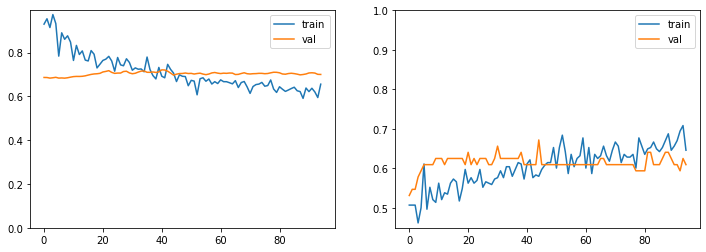

In [26]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 10. Eyes Closed  

123 of 123
77 of 77
(159, 160, 160, 3) float32
(159,) int32
(41, 160, 160, 3) float32
(41,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 195ms/step - loss: 12.7697 - val_loss: 14.6872
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 7.6804 - val_loss: 14.2227
Epoch 3/100
100/100 [==============================] - 18s 181ms/step - loss: 5.6128 - val_loss: 12.4598
Epoch 4/100
100/100 [==============================] - 18s 181ms/step - loss: 3.9132 - val_loss: 11.5731
Epoch 5/100
100/100 [==============================] - 18s 181ms/step - loss: 3.1868 - val_loss: 12.5876
Epoch 6/100
100/100 [==============================] - 18s 181ms/step - loss: 2.4835 - val_loss: 12.7661
Epoch 7/100
100/100 [==============================] - 18s 181ms/step - loss: 1.9226 - val_loss: 13.0087
Epoch 8/100
100/100 [==============================] - 18s 181ms/step - loss: 1.6673 - val_loss: 12.9130
Epoch 9/100
100/100 [==============================] - 18s 181ms/step - loss: 1.3736 - val_loss: 13.0784
Epoch 10/100
100/100 [==============================] 

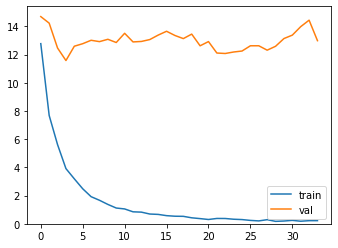

In [27]:
REQ_NAME = 'eyes_closed'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
6/6 [==============================] - 2s 394ms/step - loss: 0.7597 - accuracy: 0.5990 - precision: 0.6246 - recall: 0.5573 - f1: 0.5786 - specificity: 0.6528 - negative_predictive_value: 0.5907 - matthews_correlation_coefficient: 0.2126 - equal_error_rate: 0.4370 - val_loss: 0.8203 - val_accuracy: 0.4688 - val_precision: 0.3750 - val_recall: 0.2000 - val_f1: 0.2609 - val_specificity: 0.7059 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.1085 - val_equal_error_rate: 0.5941

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.10847, saving model to ../../models/siamese_networks/eyes_closed_2020_06_07-01_49_25.h5
Epoch 2/100
6/6 [==============================] - 1s 141ms/step - loss: 0.8114 - accuracy: 0.5244 - precision: 0.5287 - recall: 0.4786 - f1: 0.5014 - specificity: 0.5596 - negative_predictive_value: 0.5104 - matthews_correlation_coefficient: 0.0386 - equal_error_rate: 0.4369 - val_loss: 0.8157 - val_accuracy

6/6 [==============================] - 1s 135ms/step - loss: 0.7288 - accuracy: 0.5793 - precision: 0.5190 - recall: 0.4559 - f1: 0.4796 - specificity: 0.6025 - negative_predictive_value: 0.5205 - matthews_correlation_coefficient: 0.0499 - equal_error_rate: 0.4787 - val_loss: 0.8054 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.3333 - val_f1: 0.4000 - val_specificity: 0.7059 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.0422 - val_equal_error_rate: 0.5020

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.04222
Epoch 15/100
6/6 [==============================] - 1s 150ms/step - loss: 0.7683 - accuracy: 0.5625 - precision: 0.5602 - recall: 0.6048 - f1: 0.5806 - specificity: 0.5127 - negative_predictive_value: 0.5565 - matthews_correlation_coefficient: 0.1171 - equal_error_rate: 0.4373 - val_loss: 0.8059 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.3333 - val_f1: 0.4000 - val_specificity: 0.7059

6/6 [==============================] - 1s 132ms/step - loss: 0.7698 - accuracy: 0.5366 - precision: 0.5577 - recall: 0.4618 - f1: 0.4985 - specificity: 0.6122 - negative_predictive_value: 0.5200 - matthews_correlation_coefficient: 0.0758 - equal_error_rate: 0.5201 - val_loss: 0.8036 - val_accuracy: 0.5625 - val_precision: 0.5455 - val_recall: 0.4000 - val_f1: 0.4615 - val_specificity: 0.7059 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.1112 - val_equal_error_rate: 0.5020

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.11125
Epoch 28/100
6/6 [==============================] - 1s 143ms/step - loss: 0.7194 - accuracy: 0.5244 - precision: 0.5359 - recall: 0.5602 - f1: 0.5423 - specificity: 0.4843 - negative_predictive_value: 0.5091 - matthews_correlation_coefficient: 0.0447 - equal_error_rate: 0.4103 - val_loss: 0.8052 - val_accuracy: 0.5625 - val_precision: 0.5455 - val_recall: 0.4000 - val_f1: 0.4615 - val_specificity: 0.7059


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.11125
Epoch 41/100
6/6 [==============================] - 1s 134ms/step - loss: 0.6841 - accuracy: 0.6037 - precision: 0.6417 - recall: 0.6097 - f1: 0.6110 - specificity: 0.6468 - negative_predictive_value: 0.6476 - matthews_correlation_coefficient: 0.2718 - equal_error_rate: 0.3850 - val_loss: 0.8142 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.4667 - val_f1: 0.4828 - val_specificity: 0.5882 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.0552 - val_equal_error_rate: 0.5314

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.11125
Epoch 42/100
6/6 [==============================] - 1s 139ms/step - loss: 0.7052 - accuracy: 0.5976 - precision: 0.6002 - recall: 0.5957 - f1: 0.5945 - specificity: 0.5704 - negative_predictive_value: 0.5685 - matthews_correlation_coefficient: 0.1674 - equal_error_rate: 0.3742 - val_loss: 0.8131 - val_accuracy: 0

6/6 [==============================] - 1s 132ms/step - loss: 0.6657 - accuracy: 0.6098 - precision: 0.6741 - recall: 0.5267 - f1: 0.5817 - specificity: 0.7323 - negative_predictive_value: 0.6159 - matthews_correlation_coefficient: 0.2735 - equal_error_rate: 0.3699 - val_loss: 0.8118 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.4667 - val_f1: 0.4828 - val_specificity: 0.5882 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.0552 - val_equal_error_rate: 0.5314

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.11125
Epoch 55/100
6/6 [==============================] - 1s 139ms/step - loss: 0.6646 - accuracy: 0.5976 - precision: 0.6797 - recall: 0.5523 - f1: 0.5993 - specificity: 0.6909 - negative_predictive_value: 0.5899 - matthews_correlation_coefficient: 0.2554 - equal_error_rate: 0.3903 - val_loss: 0.8121 - val_accuracy: 0.5000 - val_precision: 0.4667 - val_recall: 0.4667 - val_f1: 0.4667 - val_specificity: 0.5294


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.11125
Epoch 68/100
6/6 [==============================] - 1s 136ms/step - loss: 0.7153 - accuracy: 0.5671 - precision: 0.5514 - recall: 0.5176 - f1: 0.5280 - specificity: 0.6029 - negative_predictive_value: 0.5692 - matthews_correlation_coefficient: 0.1205 - equal_error_rate: 0.3911 - val_loss: 0.8108 - val_accuracy: 0.5000 - val_precision: 0.4667 - val_recall: 0.4667 - val_f1: 0.4667 - val_specificity: 0.5294 - val_negative_predictive_value: 0.5294 - val_matthews_correlation_coefficient: -0.0039 - val_equal_error_rate: 0.5314

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.11125
Epoch 69/100
6/6 [==============================] - 1s 130ms/step - loss: 0.6700 - accuracy: 0.6098 - precision: 0.7198 - recall: 0.5177 - f1: 0.5905 - specificity: 0.7576 - negative_predictive_value: 0.5945 - matthews_correlation_coefficient: 0.2937 - equal_error_rate: 0.3946 - val_loss: 0.8108 - val_accuracy: 

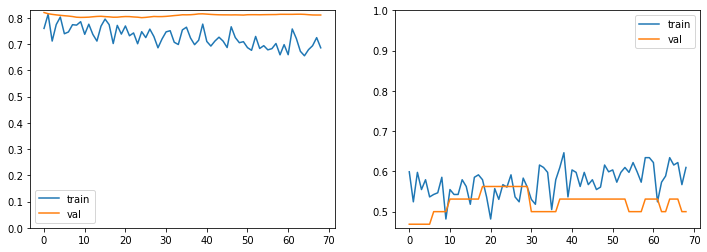

In [28]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 11. Varied Background

130 of 130
150 of 150
(224, 160, 160, 3) float32
(224,) int32
(56, 160, 160, 3) float32
(56,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 242ms/step - loss: 11.7998 - val_loss: 5.8512
Epoch 2/100
100/100 [==============================] - 22s 220ms/step - loss: 6.8305 - val_loss: 4.8287
Epoch 3/100
100/100 [==============================] - 22s 220ms/step - loss: 5.5644 - val_loss: 4.6848
Epoch 4/100
100/100 [==============================] - 22s 221ms/step - loss: 3.9062 - val_loss: 4.2354
Epoch 5/100
100/100 [==============================] - 22s 220ms/step - loss: 3.0702 - val_loss: 3.9180
Epoch 6/100
100/100 [==============================] - 22s 220ms/step - loss: 2.2224 - val_loss: 4.5029
Epoch 7/100
100/100 [==============================] - 22s 220ms/step - loss: 1.8638 - val_loss: 3.9774
Epoch 8/100
100/100 [==============================] - 22s 220ms/step - loss: 1.5419 - val_loss: 4.0596
Epoch 9/100
100/100 [==============================] - 22s 221ms/step - loss: 1.2073 - val_loss: 3.9087
Epoch 10/100
100/100 [==============================] - 22s 220

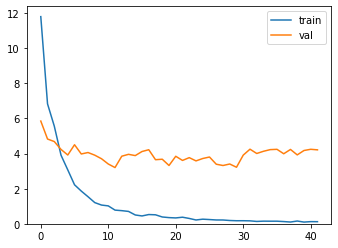

In [29]:
REQ_NAME = 'varied_background'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 2s 349ms/step - loss: 1.0675 - accuracy: 0.4330 - precision: 0.3914 - recall: 0.2267 - f1: 0.2806 - specificity: 0.6431 - negative_predictive_value: 0.4364 - matthews_correlation_coefficient: -0.1490 - equal_error_rate: 0.6024 - val_loss: 0.8920 - val_accuracy: 0.3438 - val_precision: 0.3684 - val_recall: 0.4375 - val_f1: 0.4000 - val_specificity: 0.2500 - val_negative_predictive_value: 0.3077 - val_matthews_correlation_coefficient: -0.3181 - val_equal_error_rate: 0.5938

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.31814, saving model to ../../models/siamese_networks/varied_background_2020_06_07-02_07_09.h5
Epoch 2/100
7/7 [==============================] - 1s 128ms/step - loss: 0.9567 - accuracy: 0.4375 - precision: 0.4242 - recall: 0.2940 - f1: 0.3261 - specificity: 0.6093 - negative_predictive_value: 0.4753 - matthews_correlation_coefficient: -0.0990 - equal_error_rate: 0.5601 - val_loss: 0.8601 - val_

7/7 [==============================] - 1s 131ms/step - loss: 0.6677 - accuracy: 0.6202 - precision: 0.6279 - recall: 0.4986 - f1: 0.5412 - specificity: 0.7231 - negative_predictive_value: 0.6116 - matthews_correlation_coefficient: 0.2303 - equal_error_rate: 0.4278 - val_loss: 0.6114 - val_accuracy: 0.6562 - val_precision: 0.7778 - val_recall: 0.4375 - val_f1: 0.5600 - val_specificity: 0.8750 - val_negative_predictive_value: 0.6087 - val_matthews_correlation_coefficient: 0.3475 - val_equal_error_rate: 0.2812

Epoch 00013: val_matthews_correlation_coefficient improved from 0.32898 to 0.34752, saving model to ../../models/siamese_networks/varied_background_2020_06_07-02_07_09.h5
Epoch 14/100
7/7 [==============================] - 1s 132ms/step - loss: 0.6775 - accuracy: 0.6635 - precision: 0.6835 - recall: 0.5890 - f1: 0.6099 - specificity: 0.7447 - negative_predictive_value: 0.6585 - matthews_correlation_coefficient: 0.3376 - equal_error_rate: 0.3628 - val_loss: 0.5992 - val_accuracy: 0.

7/7 [==============================] - 1s 125ms/step - loss: 0.5873 - accuracy: 0.7308 - precision: 0.7517 - recall: 0.6167 - f1: 0.6711 - specificity: 0.8331 - negative_predictive_value: 0.7028 - matthews_correlation_coefficient: 0.4519 - equal_error_rate: 0.2870 - val_loss: 0.5156 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_f1: 0.7692 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7273 - val_matthews_correlation_coefficient: 0.6742 - val_equal_error_rate: 0.2812

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.67420
Epoch 27/100
7/7 [==============================] - 1s 119ms/step - loss: 0.5982 - accuracy: 0.6923 - precision: 0.7365 - recall: 0.5567 - f1: 0.6216 - specificity: 0.8254 - negative_predictive_value: 0.6653 - matthews_correlation_coefficient: 0.3915 - equal_error_rate: 0.2926 - val_loss: 0.5125 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_f1: 0.7692 - val_specificity: 1.0000


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.67420
Epoch 40/100
7/7 [==============================] - 1s 128ms/step - loss: 0.5433 - accuracy: 0.7596 - precision: 0.7934 - recall: 0.7002 - f1: 0.7299 - specificity: 0.8307 - negative_predictive_value: 0.7306 - matthews_correlation_coefficient: 0.5269 - equal_error_rate: 0.2723 - val_loss: 0.4904 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_f1: 0.7692 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7273 - val_matthews_correlation_coefficient: 0.6742 - val_equal_error_rate: 0.2188

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.67420
Epoch 41/100
7/7 [==============================] - 1s 124ms/step - loss: 0.5032 - accuracy: 0.7634 - precision: 0.8339 - recall: 0.6714 - f1: 0.7422 - specificity: 0.8633 - negative_predictive_value: 0.7115 - matthews_correlation_coefficient: 0.5400 - equal_error_rate: 0.2493 - val_loss: 0.4895 - val_accuracy: 0

7/7 [==============================] - 1s 122ms/step - loss: 0.5175 - accuracy: 0.7885 - precision: 0.8427 - recall: 0.7290 - f1: 0.7701 - specificity: 0.8805 - negative_predictive_value: 0.7597 - matthews_correlation_coefficient: 0.6051 - equal_error_rate: 0.2195 - val_loss: 0.4849 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_f1: 0.7692 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7273 - val_matthews_correlation_coefficient: 0.6742 - val_equal_error_rate: 0.2188

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.67420
Epoch 54/100
7/7 [==============================] - 1s 127ms/step - loss: 0.5171 - accuracy: 0.7692 - precision: 0.7678 - recall: 0.6891 - f1: 0.7194 - specificity: 0.8301 - negative_predictive_value: 0.7501 - matthews_correlation_coefficient: 0.5184 - equal_error_rate: 0.2663 - val_loss: 0.4829 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_f1: 0.7692 - val_specificity: 1.0000


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.67420
Epoch 67/100
7/7 [==============================] - 1s 124ms/step - loss: 0.4819 - accuracy: 0.7692 - precision: 0.8090 - recall: 0.7207 - f1: 0.7398 - specificity: 0.8507 - negative_predictive_value: 0.7534 - matthews_correlation_coefficient: 0.5659 - equal_error_rate: 0.1873 - val_loss: 0.4680 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_f1: 0.7692 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7273 - val_matthews_correlation_coefficient: 0.6742 - val_equal_error_rate: 0.1562
Restoring model weights from the end of the best epoch

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.67420
Epoch 00067: early stopping

   Final Accuracy:  76.79%
  Final Precision:  88.24%
     Final Recall:  57.69%
  Final F-measure:  69.77%
Final Specificity:  93.33%
        Final NPV:  71.79%
        Final MCC:  55.35%

[[28  2]
 [11 15]]
              precisi

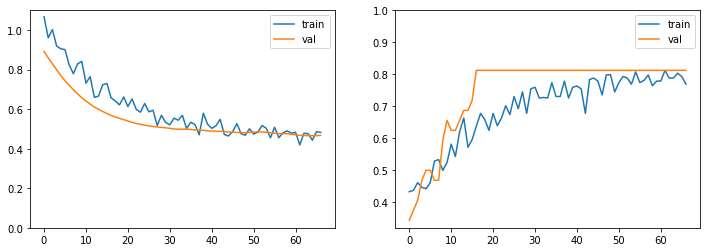

In [30]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 12. Roll/pitch/yaw

150 of 150
141 of 141
(232, 160, 160, 3) float32
(232,) int32
(59, 160, 160, 3) float32
(59,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 256ms/step - loss: 16.9941 - val_loss: 18.2210
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 14.3681 - val_loss: 18.6690
Epoch 3/100
100/100 [==============================] - 23s 229ms/step - loss: 12.2287 - val_loss: 19.1078
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 11.1175 - val_loss: 18.8754
Epoch 5/100
100/100 [==============================] - 23s 231ms/step - loss: 10.1458 - val_loss: 19.7506
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 8.9114 - val_loss: 19.1304
Epoch 7/100
100/100 [==============================] - 23s 232ms/step - loss: 8.3949 - val_loss: 20.7478
Epoch 8/100
100/100 [==============================] - 24s 237ms/step - loss: 7.8769 - val_loss: 20.6627
Epoch 9/100
100/100 [==============================] - 24s 240ms/step - loss: 7.1337 - val_loss: 19.6683
Epoch 10/100
100/100 [============================

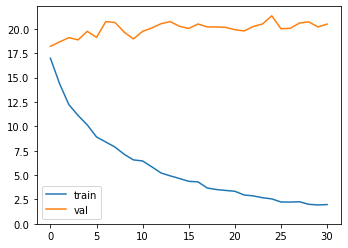

In [31]:
REQ_NAME = 'roll_pitch_yaw'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 380ms/step - loss: 0.8037 - accuracy: 0.4554 - precision: 0.4665 - recall: 0.4063 - f1: 0.4250 - specificity: 0.5109 - negative_predictive_value: 0.4513 - matthews_correlation_coefficient: -0.0825 - equal_error_rate: 0.5272 - val_loss: 0.7343 - val_accuracy: 0.4375 - val_precision: 0.4118 - val_recall: 0.4667 - val_f1: 0.4375 - val_specificity: 0.4118 - val_negative_predictive_value: 0.4667 - val_matthews_correlation_coefficient: -0.1216 - val_equal_error_rate: 0.5941

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.12157, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_07-02_21_47.h5
Epoch 2/100
7/7 [==============================] - 1s 130ms/step - loss: 0.7490 - accuracy: 0.5048 - precision: 0.4780 - recall: 0.4336 - f1: 0.4458 - specificity: 0.5873 - negative_predictive_value: 0.5351 - matthews_correlation_coefficient: 0.0169 - equal_error_rate: 0.5092 - val_loss: 0.7322 - val_accu

7/7 [==============================] - 1s 133ms/step - loss: 0.7022 - accuracy: 0.5481 - precision: 0.5330 - recall: 0.5181 - f1: 0.5144 - specificity: 0.5621 - negative_predictive_value: 0.5455 - matthews_correlation_coefficient: 0.0794 - equal_error_rate: 0.4474 - val_loss: 0.7031 - val_accuracy: 0.4375 - val_precision: 0.4211 - val_recall: 0.5333 - val_f1: 0.4706 - val_specificity: 0.3529 - val_negative_predictive_value: 0.4615 - val_matthews_correlation_coefficient: -0.1156 - val_equal_error_rate: 0.5314

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.11555
Epoch 15/100
7/7 [==============================] - 1s 130ms/step - loss: 0.7525 - accuracy: 0.5048 - precision: 0.5278 - recall: 0.4760 - f1: 0.4858 - specificity: 0.5564 - negative_predictive_value: 0.5050 - matthews_correlation_coefficient: 0.0326 - equal_error_rate: 0.5011 - val_loss: 0.7016 - val_accuracy: 0.4375 - val_precision: 0.4211 - val_recall: 0.5333 - val_f1: 0.4706 - val_specificity: 0.35

7/7 [==============================] - 1s 132ms/step - loss: 0.7117 - accuracy: 0.5385 - precision: 0.5035 - recall: 0.4932 - f1: 0.4931 - specificity: 0.5745 - negative_predictive_value: 0.5632 - matthews_correlation_coefficient: 0.0672 - equal_error_rate: 0.4797 - val_loss: 0.6939 - val_accuracy: 0.4688 - val_precision: 0.4500 - val_recall: 0.6000 - val_f1: 0.5143 - val_specificity: 0.3529 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0485 - val_equal_error_rate: 0.5314

Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.04851
Epoch 28/100
7/7 [==============================] - 1s 134ms/step - loss: 0.7712 - accuracy: 0.4808 - precision: 0.4581 - recall: 0.4284 - f1: 0.4339 - specificity: 0.5251 - negative_predictive_value: 0.5044 - matthews_correlation_coefficient: -0.0419 - equal_error_rate: 0.5442 - val_loss: 0.6943 - val_accuracy: 0.4688 - val_precision: 0.4500 - val_recall: 0.6000 - val_f1: 0.5143 - val_specificity: 0.3

7/7 [==============================] - 1s 135ms/step - loss: 0.6853 - accuracy: 0.6106 - precision: 0.5967 - recall: 0.6541 - f1: 0.6028 - specificity: 0.6031 - negative_predictive_value: 0.6467 - matthews_correlation_coefficient: 0.2501 - equal_error_rate: 0.3722 - val_loss: 0.6895 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.4118 - val_negative_predictive_value: 0.5833 - val_matthews_correlation_coefficient: 0.0808 - val_equal_error_rate: 0.5314

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.08085
Epoch 41/100
7/7 [==============================] - 1s 139ms/step - loss: 0.7373 - accuracy: 0.5223 - precision: 0.5358 - recall: 0.5216 - f1: 0.5156 - specificity: 0.5316 - negative_predictive_value: 0.5130 - matthews_correlation_coefficient: 0.0509 - equal_error_rate: 0.5040 - val_loss: 0.6878 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.4118


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.08085
Epoch 54/100
7/7 [==============================] - 1s 136ms/step - loss: 0.7064 - accuracy: 0.5096 - precision: 0.5111 - recall: 0.5301 - f1: 0.5018 - specificity: 0.5414 - negative_predictive_value: 0.5411 - matthews_correlation_coefficient: 0.0615 - equal_error_rate: 0.4366 - val_loss: 0.6786 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.6000 - val_f1: 0.5455 - val_specificity: 0.4706 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.0710 - val_equal_error_rate: 0.5020

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.08085
Epoch 55/100
7/7 [==============================] - 1s 134ms/step - loss: 0.6756 - accuracy: 0.5913 - precision: 0.6268 - recall: 0.5664 - f1: 0.5909 - specificity: 0.6355 - negative_predictive_value: 0.5708 - matthews_correlation_coefficient: 0.1997 - equal_error_rate: 0.4235 - val_loss: 0.6782 - val_accuracy: 0

7/7 [==============================] - 1s 133ms/step - loss: 0.6765 - accuracy: 0.5288 - precision: 0.5041 - recall: 0.5909 - f1: 0.5313 - specificity: 0.4921 - negative_predictive_value: 0.5729 - matthews_correlation_coefficient: 0.0799 - equal_error_rate: 0.4394 - val_loss: 0.6739 - val_accuracy: 0.5625 - val_precision: 0.5263 - val_recall: 0.6667 - val_f1: 0.5882 - val_specificity: 0.4706 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.1395 - val_equal_error_rate: 0.4392

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.19724
Epoch 68/100
7/7 [==============================] - 1s 135ms/step - loss: 0.6723 - accuracy: 0.5962 - precision: 0.5869 - recall: 0.6279 - f1: 0.5928 - specificity: 0.6131 - negative_predictive_value: 0.6308 - matthews_correlation_coefficient: 0.2289 - equal_error_rate: 0.3842 - val_loss: 0.6732 - val_accuracy: 0.5625 - val_precision: 0.5263 - val_recall: 0.6667 - val_f1: 0.5882 - val_specificity: 0.4706


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.19724
Epoch 81/100
7/7 [==============================] - 1s 134ms/step - loss: 0.6756 - accuracy: 0.5938 - precision: 0.6195 - recall: 0.5590 - f1: 0.5805 - specificity: 0.6321 - negative_predictive_value: 0.5696 - matthews_correlation_coefficient: 0.1900 - equal_error_rate: 0.4108 - val_loss: 0.6738 - val_accuracy: 0.5312 - val_precision: 0.5000 - val_recall: 0.6000 - val_f1: 0.5455 - val_specificity: 0.4706 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.0710 - val_equal_error_rate: 0.5020

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.19724
Epoch 82/100
7/7 [==============================] - 1s 129ms/step - loss: 0.6770 - accuracy: 0.6010 - precision: 0.6095 - recall: 0.5320 - f1: 0.5570 - specificity: 0.6666 - negative_predictive_value: 0.6080 - matthews_correlation_coefficient: 0.2072 - equal_error_rate: 0.4226 - val_loss: 0.6739 - val_accuracy: 0

7/7 [==============================] - 1s 137ms/step - loss: 0.6853 - accuracy: 0.5529 - precision: 0.5769 - recall: 0.6033 - f1: 0.5574 - specificity: 0.5570 - negative_predictive_value: 0.5822 - matthews_correlation_coefficient: 0.1595 - equal_error_rate: 0.4262 - val_loss: 0.6719 - val_accuracy: 0.5625 - val_precision: 0.5294 - val_recall: 0.6000 - val_f1: 0.5625 - val_specificity: 0.5294 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.1294 - val_equal_error_rate: 0.4392

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.19724
Epoch 95/100
7/7 [==============================] - 1s 138ms/step - loss: 0.7003 - accuracy: 0.5240 - precision: 0.5420 - recall: 0.5286 - f1: 0.5244 - specificity: 0.5277 - negative_predictive_value: 0.5094 - matthews_correlation_coefficient: 0.0539 - equal_error_rate: 0.4138 - val_loss: 0.6716 - val_accuracy: 0.5625 - val_precision: 0.5294 - val_recall: 0.6000 - val_f1: 0.5625 - val_specificity: 0.5294

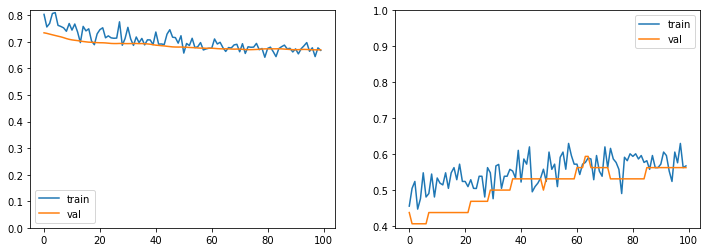

In [32]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 13. Flash Reflection on Skin

84 of 84
70 of 70
(123, 160, 160, 3) float32
(123,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 202ms/step - loss: 12.8127 - val_loss: 10.1208
Epoch 2/100
100/100 [==============================] - 18s 182ms/step - loss: 6.6554 - val_loss: 7.4959
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 4.6251 - val_loss: 4.6541
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 3.4635 - val_loss: 5.0984
Epoch 5/100
100/100 [==============================] - 18s 179ms/step - loss: 2.6139 - val_loss: 6.0323
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 1.8946 - val_loss: 5.6182
Epoch 7/100
100/100 [==============================] - 18s 179ms/step - loss: 1.6420 - val_loss: 5.9630
Epoch 8/100
100/100 [==============================] - 18s 179ms/step - loss: 1.1550 - val_loss: 7.0271
Epoch 9/100
100/100 [==============================] - 18s 179ms/step - loss: 1.0135 - val_loss: 6.6896
Epoch 10/100
100/100 [==============================] - 18s 17

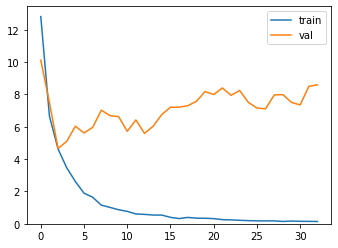

In [33]:
REQ_NAME = 'flash_reflection_on_skin'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 2s 611ms/step - loss: 0.8018 - accuracy: 0.6016 - precision: 0.7521 - recall: 0.2915 - f1: 0.4198 - specificity: 0.9077 - negative_predictive_value: 0.5601 - matthews_correlation_coefficient: 0.2486 - equal_error_rate: 0.4374 - val_loss: 0.8481 - val_accuracy: 0.5484 - val_precision: 0.5714 - val_recall: 0.5000 - val_f1: 0.5333 - val_specificity: 0.6000 - val_negative_predictive_value: 0.5294 - val_matthews_correlation_coefficient: 0.1004 - val_equal_error_rate: 0.4833

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10042, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_07-02_34_48.h5
Epoch 2/100
4/4 [==============================] - 1s 174ms/step - loss: 0.8020 - accuracy: 0.6373 - precision: 0.6331 - recall: 0.3654 - f1: 0.4607 - specificity: 0.8154 - negative_predictive_value: 0.5940 - matthews_correlation_coefficient: 0.2021 - equal_error_rate: 0.4773 - val_loss: 0.8277 - v

4/4 [==============================] - 1s 139ms/step - loss: 0.6907 - accuracy: 0.5294 - precision: 0.4357 - recall: 0.3003 - f1: 0.3497 - specificity: 0.7556 - negative_predictive_value: 0.4992 - matthews_correlation_coefficient: 0.0576 - equal_error_rate: 0.3625 - val_loss: 0.6859 - val_accuracy: 0.6452 - val_precision: 0.6190 - val_recall: 0.8125 - val_f1: 0.7027 - val_specificity: 0.4667 - val_negative_predictive_value: 0.7000 - val_matthews_correlation_coefficient: 0.2984 - val_equal_error_rate: 0.4187

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35446
Epoch 15/100
4/4 [==============================] - 1s 136ms/step - loss: 0.6401 - accuracy: 0.6078 - precision: 0.6238 - recall: 0.4775 - f1: 0.5384 - specificity: 0.6974 - negative_predictive_value: 0.5559 - matthews_correlation_coefficient: 0.1773 - equal_error_rate: 0.4123 - val_loss: 0.6831 - val_accuracy: 0.6452 - val_precision: 0.6190 - val_recall: 0.8125 - val_f1: 0.7027 - val_specificity: 0.4667

4/4 [==============================] - 1s 141ms/step - loss: 0.5923 - accuracy: 0.6667 - precision: 0.7292 - recall: 0.6374 - f1: 0.6770 - specificity: 0.8183 - negative_predictive_value: 0.7375 - matthews_correlation_coefficient: 0.4611 - equal_error_rate: 0.3470 - val_loss: 0.6724 - val_accuracy: 0.6774 - val_precision: 0.6250 - val_recall: 0.9375 - val_f1: 0.7500 - val_specificity: 0.4000 - val_negative_predictive_value: 0.8571 - val_matthews_correlation_coefficient: 0.4034 - val_equal_error_rate: 0.4187

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.40339
Epoch 28/100
4/4 [==============================] - 1s 145ms/step - loss: 0.6370 - accuracy: 0.5686 - precision: 0.5860 - recall: 0.5674 - f1: 0.5690 - specificity: 0.6148 - negative_predictive_value: 0.5992 - matthews_correlation_coefficient: 0.1837 - equal_error_rate: 0.3472 - val_loss: 0.6725 - val_accuracy: 0.6774 - val_precision: 0.6250 - val_recall: 0.9375 - val_f1: 0.7500 - val_specificity: 0.4000


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.40339
Epoch 41/100
4/4 [==============================] - 1s 152ms/step - loss: 0.6967 - accuracy: 0.6250 - precision: 0.6377 - recall: 0.5914 - f1: 0.6073 - specificity: 0.6600 - negative_predictive_value: 0.6156 - matthews_correlation_coefficient: 0.2523 - equal_error_rate: 0.3898 - val_loss: 0.6763 - val_accuracy: 0.6774 - val_precision: 0.6364 - val_recall: 0.8750 - val_f1: 0.7368 - val_specificity: 0.4667 - val_negative_predictive_value: 0.7778 - val_matthews_correlation_coefficient: 0.3762 - val_equal_error_rate: 0.4833

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.40339
Epoch 42/100
4/4 [==============================] - 1s 138ms/step - loss: 0.5774 - accuracy: 0.6569 - precision: 0.7201 - recall: 0.5898 - f1: 0.6442 - specificity: 0.7751 - negative_predictive_value: 0.6755 - matthews_correlation_coefficient: 0.3799 - equal_error_rate: 0.3560 - val_loss: 0.6754 - val_accuracy: 0

4/4 [==============================] - 1s 147ms/step - loss: 0.6718 - accuracy: 0.5588 - precision: 0.5656 - recall: 0.5117 - f1: 0.5329 - specificity: 0.5778 - negative_predictive_value: 0.5217 - matthews_correlation_coefficient: 0.0884 - equal_error_rate: 0.4368 - val_loss: 0.6723 - val_accuracy: 0.6774 - val_precision: 0.6250 - val_recall: 0.9375 - val_f1: 0.7500 - val_specificity: 0.4000 - val_negative_predictive_value: 0.8571 - val_matthews_correlation_coefficient: 0.4034 - val_equal_error_rate: 0.4833

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.46159
Epoch 55/100
4/4 [==============================] - 1s 144ms/step - loss: 0.6069 - accuracy: 0.7353 - precision: 0.8260 - recall: 0.7003 - f1: 0.7449 - specificity: 0.8252 - negative_predictive_value: 0.7167 - matthews_correlation_coefficient: 0.5336 - equal_error_rate: 0.2357 - val_loss: 0.6732 - val_accuracy: 0.7097 - val_precision: 0.6522 - val_recall: 0.9375 - val_f1: 0.7692 - val_specificity: 0.4667


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.46159
Epoch 68/100
4/4 [==============================] - 1s 144ms/step - loss: 0.6758 - accuracy: 0.5784 - precision: 0.5929 - recall: 0.5691 - f1: 0.5775 - specificity: 0.6224 - negative_predictive_value: 0.5969 - matthews_correlation_coefficient: 0.1907 - equal_error_rate: 0.3463 - val_loss: 0.6806 - val_accuracy: 0.6774 - val_precision: 0.6364 - val_recall: 0.8750 - val_f1: 0.7368 - val_specificity: 0.4667 - val_negative_predictive_value: 0.7778 - val_matthews_correlation_coefficient: 0.3762 - val_equal_error_rate: 0.4833

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.46159
Epoch 69/100
4/4 [==============================] - 1s 152ms/step - loss: 0.6725 - accuracy: 0.6078 - precision: 0.6031 - recall: 0.6338 - f1: 0.6153 - specificity: 0.5181 - negative_predictive_value: 0.5502 - matthews_correlation_coefficient: 0.1526 - equal_error_rate: 0.3291 - val_loss: 0.6825 - val_accuracy: 0

4/4 [==============================] - 1s 154ms/step - loss: 0.6227 - accuracy: 0.6875 - precision: 0.7024 - recall: 0.6603 - f1: 0.6753 - specificity: 0.7231 - negative_predictive_value: 0.6746 - matthews_correlation_coefficient: 0.3801 - equal_error_rate: 0.3132 - val_loss: 0.6829 - val_accuracy: 0.6452 - val_precision: 0.6087 - val_recall: 0.8750 - val_f1: 0.7179 - val_specificity: 0.4000 - val_negative_predictive_value: 0.7500 - val_matthews_correlation_coefficient: 0.3141 - val_equal_error_rate: 0.4833

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.46159
Epoch 82/100
4/4 [==============================] - 1s 147ms/step - loss: 0.6191 - accuracy: 0.6667 - precision: 0.7130 - recall: 0.7175 - f1: 0.7095 - specificity: 0.7579 - negative_predictive_value: 0.7614 - matthews_correlation_coefficient: 0.4749 - equal_error_rate: 0.3162 - val_loss: 0.6830 - val_accuracy: 0.6452 - val_precision: 0.6087 - val_recall: 0.8750 - val_f1: 0.7179 - val_specificity: 0.4000

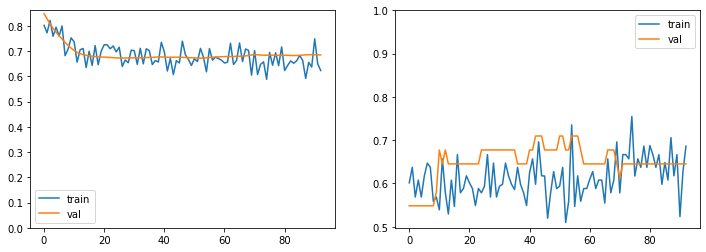

In [34]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 14. Red Eyes 

78 of 78
39 of 39
(93, 160, 160, 3) float32
(93,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 18s 175ms/step - loss: 13.8406 - val_loss: 9.7918
Epoch 2/100
100/100 [==============================] - 16s 157ms/step - loss: 6.3217 - val_loss: 5.7042
Epoch 3/100
100/100 [==============================] - 16s 158ms/step - loss: 3.4926 - val_loss: 5.3199
Epoch 4/100
100/100 [==============================] - 16s 158ms/step - loss: 2.1114 - val_loss: 5.8436
Epoch 5/100
100/100 [==============================] - 16s 158ms/step - loss: 1.3424 - val_loss: 5.9458
Epoch 6/100
100/100 [==============================] - 16s 158ms/step - loss: 0.8986 - val_loss: 5.8917
Epoch 7/100
100/100 [==============================] - 16s 157ms/step - loss: 0.8053 - val_loss: 6.5382
Epoch 8/100
100/100 [==============================] - 16s 157ms/step - loss: 0.5836 - val_loss: 5.8384
Epoch 9/100
100/100 [==============================] - 16s 158ms/step - loss: 0.4686 - val_loss: 6.2243
Epoch 10/100
100/100 [==============================] - 16s 157

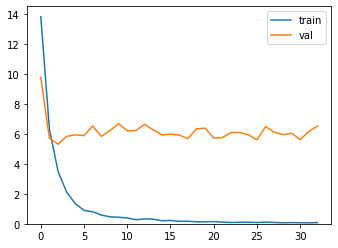

In [35]:
REQ_NAME = 'red_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 3s 867ms/step - loss: 0.6933 - accuracy: 0.5833 - precision: 0.5675 - recall: 0.6824 - f1: 0.6159 - specificity: 0.4941 - negative_predictive_value: 0.6143 - matthews_correlation_coefficient: 0.1791 - equal_error_rate: 0.3444 - val_loss: 0.7588 - val_accuracy: 0.4583 - val_precision: 0.4286 - val_recall: 0.5455 - val_f1: 0.4800 - val_specificity: 0.3846 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0707 - val_equal_error_rate: 0.5420

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.07068, saving model to ../../models/siamese_networks/red_eyes_2020_06_07-02_46_06.h5
Epoch 2/100
3/3 [==============================] - 0s 161ms/step - loss: 0.6481 - accuracy: 0.6630 - precision: 0.7259 - recall: 0.5490 - f1: 0.6211 - specificity: 0.7814 - negative_predictive_value: 0.6253 - matthews_correlation_coefficient: 0.3406 - equal_error_rate: 0.3527 - val_loss: 0.7504 - val_accuracy: 0

3/3 [==============================] - 0s 149ms/step - loss: 0.5388 - accuracy: 0.7609 - precision: 0.8598 - recall: 0.6379 - f1: 0.7314 - specificity: 0.8907 - negative_predictive_value: 0.7003 - matthews_correlation_coefficient: 0.5441 - equal_error_rate: 0.2600 - val_loss: 0.6981 - val_accuracy: 0.4167 - val_precision: 0.4211 - val_recall: 0.7273 - val_f1: 0.5333 - val_specificity: 0.1538 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.1459 - val_equal_error_rate: 0.3357

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.02159
Epoch 15/100
3/3 [==============================] - 0s 142ms/step - loss: 0.6168 - accuracy: 0.7174 - precision: 0.7965 - recall: 0.5333 - f1: 0.6340 - specificity: 0.8959 - negative_predictive_value: 0.6759 - matthews_correlation_coefficient: 0.4499 - equal_error_rate: 0.3480 - val_loss: 0.6950 - val_accuracy: 0.4167 - val_precision: 0.4211 - val_recall: 0.7273 - val_f1: 0.5333 - val_specificity: 0.153


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.02159
Epoch 28/100
3/3 [==============================] - 0s 147ms/step - loss: 0.5158 - accuracy: 0.7935 - precision: 0.9267 - recall: 0.6353 - f1: 0.7434 - specificity: 0.9548 - negative_predictive_value: 0.7300 - matthews_correlation_coefficient: 0.6208 - equal_error_rate: 0.2361 - val_loss: 0.6832 - val_accuracy: 0.4583 - val_precision: 0.4500 - val_recall: 0.8182 - val_f1: 0.5806 - val_specificity: 0.1538 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0374 - val_equal_error_rate: 0.3357

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.02159
Epoch 29/100
3/3 [==============================] - 0s 144ms/step - loss: 0.5491 - accuracy: 0.8333 - precision: 0.9444 - recall: 0.7046 - f1: 0.8051 - specificity: 0.9608 - negative_predictive_value: 0.7714 - matthews_correlation_coefficient: 0.6901 - equal_error_rate: 0.2190 - val_loss: 0.6834 - val_accuracy: 

3/3 [==============================] - 0s 153ms/step - loss: 0.6240 - accuracy: 0.7500 - precision: 0.9000 - recall: 0.5542 - f1: 0.6841 - specificity: 0.9412 - negative_predictive_value: 0.6871 - matthews_correlation_coefficient: 0.5393 - equal_error_rate: 0.2817 - val_loss: 0.6877 - val_accuracy: 0.4583 - val_precision: 0.4500 - val_recall: 0.8182 - val_f1: 0.5806 - val_specificity: 0.1538 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0374 - val_equal_error_rate: 0.2517

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.02159
Epoch 42/100
3/3 [==============================] - 0s 145ms/step - loss: 0.4606 - accuracy: 0.8587 - precision: 0.9722 - recall: 0.7490 - f1: 0.8455 - specificity: 0.9778 - negative_predictive_value: 0.7875 - matthews_correlation_coefficient: 0.7430 - equal_error_rate: 0.1703 - val_loss: 0.6877 - val_accuracy: 0.4583 - val_precision: 0.4500 - val_recall: 0.8182 - val_f1: 0.5806 - val_specificity: 0.153

3/3 [==============================] - 0s 142ms/step - loss: 0.4406 - accuracy: 0.8261 - precision: 0.9744 - recall: 0.6797 - f1: 0.8000 - specificity: 0.9778 - negative_predictive_value: 0.7439 - matthews_correlation_coefficient: 0.6870 - equal_error_rate: 0.1285 - val_loss: 0.6851 - val_accuracy: 0.5000 - val_precision: 0.4762 - val_recall: 0.9091 - val_f1: 0.6250 - val_specificity: 0.1538 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.0948 - val_equal_error_rate: 0.2517

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.09482
Epoch 55/100
3/3 [==============================] - 0s 147ms/step - loss: 0.5662 - accuracy: 0.7935 - precision: 0.8778 - recall: 0.6667 - f1: 0.7565 - specificity: 0.9216 - negative_predictive_value: 0.7481 - matthews_correlation_coefficient: 0.6066 - equal_error_rate: 0.2054 - val_loss: 0.6835 - val_accuracy: 0.5000 - val_precision: 0.4762 - val_recall: 0.9091 - val_f1: 0.6250 - val_specificity: 0.1538


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.09482
Epoch 68/100
3/3 [==============================] - 0s 144ms/step - loss: 0.4573 - accuracy: 0.8370 - precision: 0.9744 - recall: 0.6993 - f1: 0.8065 - specificity: 0.9744 - negative_predictive_value: 0.7659 - matthews_correlation_coefficient: 0.7049 - equal_error_rate: 0.1494 - val_loss: 0.6773 - val_accuracy: 0.5000 - val_precision: 0.4762 - val_recall: 0.9091 - val_f1: 0.6250 - val_specificity: 0.1538 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.0948 - val_equal_error_rate: 0.2517

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.09482
Epoch 69/100
3/3 [==============================] - 0s 147ms/step - loss: 0.5099 - accuracy: 0.8333 - precision: 0.9697 - recall: 0.6824 - f1: 0.8004 - specificity: 0.9804 - negative_predictive_value: 0.7619 - matthews_correlation_coefficient: 0.6963 - equal_error_rate: 0.1980 - val_loss: 0.6768 - val_accuracy: 0

3/3 [==============================] - 0s 153ms/step - loss: 0.5502 - accuracy: 0.8125 - precision: 0.9091 - recall: 0.6850 - f1: 0.7739 - specificity: 0.9412 - negative_predictive_value: 0.7643 - matthews_correlation_coefficient: 0.6490 - equal_error_rate: 0.1882 - val_loss: 0.6668 - val_accuracy: 0.5000 - val_precision: 0.4762 - val_recall: 0.9091 - val_f1: 0.6250 - val_specificity: 0.1538 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.0948 - val_equal_error_rate: 0.2517

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.09482
Epoch 82/100
3/3 [==============================] - 0s 147ms/step - loss: 0.4212 - accuracy: 0.8913 - precision: 0.9744 - recall: 0.8105 - f1: 0.8841 - specificity: 0.9804 - negative_predictive_value: 0.8327 - matthews_correlation_coefficient: 0.7989 - equal_error_rate: 0.1076 - val_loss: 0.6658 - val_accuracy: 0.5000 - val_precision: 0.4762 - val_recall: 0.9091 - val_f1: 0.6250 - val_specificity: 0.1538


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.09482
Epoch 95/100
3/3 [==============================] - 0s 146ms/step - loss: 0.4139 - accuracy: 0.8587 - precision: 0.9333 - recall: 0.7556 - f1: 0.8315 - specificity: 0.9608 - negative_predictive_value: 0.8129 - matthews_correlation_coefficient: 0.7309 - equal_error_rate: 0.1187 - val_loss: 0.6525 - val_accuracy: 0.4167 - val_precision: 0.4348 - val_recall: 0.9091 - val_f1: 0.5882 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2267 - val_equal_error_rate: 0.2517

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.09482
Epoch 96/100
3/3 [==============================] - 0s 152ms/step - loss: 0.4611 - accuracy: 0.8478 - precision: 1.0000 - recall: 0.7020 - f1: 0.8173 - specificity: 1.0000 - negative_predictive_value: 0.7750 - matthews_correlation_coefficient: 0.7363 - equal_error_rate: 0.1913 - val_loss: 0.6522 - val_ac

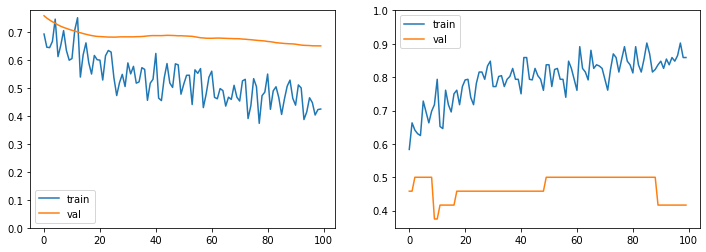

In [36]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 15. Shadows Behind Head 

99 of 99
94 of 94
(154, 160, 160, 3) float32
(154,) int32
(39, 160, 160, 3) float32
(39,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 236ms/step - loss: 11.9902 - val_loss: 14.4238
Epoch 2/100
100/100 [==============================] - 20s 199ms/step - loss: 8.0549 - val_loss: 12.2730
Epoch 3/100
100/100 [==============================] - 20s 199ms/step - loss: 6.0941 - val_loss: 12.2640
Epoch 4/100
100/100 [==============================] - 20s 199ms/step - loss: 4.7192 - val_loss: 11.4212
Epoch 5/100
100/100 [==============================] - 20s 200ms/step - loss: 3.6489 - val_loss: 9.7527
Epoch 6/100
100/100 [==============================] - 20s 199ms/step - loss: 3.1620 - val_loss: 12.2453
Epoch 7/100
100/100 [==============================] - 20s 200ms/step - loss: 2.4802 - val_loss: 11.4439
Epoch 8/100
100/100 [==============================] - 20s 200ms/step - loss: 2.0925 - val_loss: 10.4253
Epoch 9/100
100/100 [==============================] - 20s 200ms/step - loss: 1.8110 - val_loss: 10.9713
Epoch 10/100
100/100 [==============================] -

Epoch 79/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0720 - val_loss: 6.8991
Epoch 80/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0294 - val_loss: 6.3932
Epoch 81/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0464 - val_loss: 6.9326
Epoch 82/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0507 - val_loss: 6.5825
Epoch 83/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0435 - val_loss: 6.1648
Epoch 84/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0513 - val_loss: 6.3743
Epoch 85/100
100/100 [==============================] - 20s 201ms/step - loss: 0.0604 - val_loss: 6.6451
Epoch 86/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0781 - val_loss: 7.8872
Epoch 87/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0597 - val_loss: 7.2439
Epoch 88/100
100/100 [==============================] -

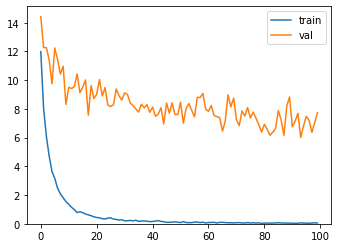

In [37]:
REQ_NAME = 'shadows_behind_head'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 699ms/step - loss: 0.8327 - accuracy: 0.5938 - precision: 0.6514 - recall: 0.4715 - f1: 0.5278 - specificity: 0.7171 - negative_predictive_value: 0.5789 - matthews_correlation_coefficient: 0.2080 - equal_error_rate: 0.4456 - val_loss: 0.8151 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2941 - val_f1: 0.4545 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.4042 - val_equal_error_rate: 0.3431

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40423, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_07-03_22_10.h5
Epoch 2/100
4/4 [==============================] - 1s 141ms/step - loss: 0.9755 - accuracy: 0.5159 - precision: 0.4860 - recall: 0.4382 - f1: 0.4581 - specificity: 0.5846 - negative_predictive_value: 0.5339 - matthews_correlation_coefficient: 0.0214 - equal_error_rate: 0.4943 - val_loss: 0.8197 - val_ac

4/4 [==============================] - 1s 143ms/step - loss: 0.7620 - accuracy: 0.6270 - precision: 0.6814 - recall: 0.5873 - f1: 0.6001 - specificity: 0.7106 - negative_predictive_value: 0.6330 - matthews_correlation_coefficient: 0.3055 - equal_error_rate: 0.3846 - val_loss: 0.7830 - val_accuracy: 0.5938 - val_precision: 1.0000 - val_recall: 0.2353 - val_f1: 0.3810 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5357 - val_matthews_correlation_coefficient: 0.3550 - val_equal_error_rate: 0.3431

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.40423
Epoch 15/100
4/4 [==============================] - 1s 127ms/step - loss: 0.8336 - accuracy: 0.5317 - precision: 0.5979 - recall: 0.3841 - f1: 0.4636 - specificity: 0.7041 - negative_predictive_value: 0.5005 - matthews_correlation_coefficient: 0.0931 - equal_error_rate: 0.4193 - val_loss: 0.7803 - val_accuracy: 0.5938 - val_precision: 1.0000 - val_recall: 0.2353 - val_f1: 0.3810 - val_specificity: 1.0000


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.40423
Epoch 28/100
4/4 [==============================] - 1s 133ms/step - loss: 0.6905 - accuracy: 0.6587 - precision: 0.7313 - recall: 0.5167 - f1: 0.6016 - specificity: 0.8013 - negative_predictive_value: 0.6096 - matthews_correlation_coefficient: 0.3291 - equal_error_rate: 0.3706 - val_loss: 0.7541 - val_accuracy: 0.5625 - val_precision: 1.0000 - val_recall: 0.1765 - val_f1: 0.3000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5172 - val_matthews_correlation_coefficient: 0.3021 - val_equal_error_rate: 0.4059

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.40423
Epoch 29/100
4/4 [==============================] - 1s 128ms/step - loss: 0.6811 - accuracy: 0.6587 - precision: 0.7165 - recall: 0.5020 - f1: 0.5897 - specificity: 0.8027 - negative_predictive_value: 0.6176 - matthews_correlation_coefficient: 0.3189 - equal_error_rate: 0.3417 - val_loss: 0.7529 - val_accuracy: 0

4/4 [==============================] - 1s 134ms/step - loss: 0.7081 - accuracy: 0.6172 - precision: 0.6750 - recall: 0.4034 - f1: 0.5007 - specificity: 0.8240 - negative_predictive_value: 0.5944 - matthews_correlation_coefficient: 0.2475 - equal_error_rate: 0.3975 - val_loss: 0.7339 - val_accuracy: 0.5625 - val_precision: 1.0000 - val_recall: 0.1765 - val_f1: 0.3000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5172 - val_matthews_correlation_coefficient: 0.3021 - val_equal_error_rate: 0.4059

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.40423
Epoch 42/100
4/4 [==============================] - 0s 125ms/step - loss: 0.6623 - accuracy: 0.6984 - precision: 0.7303 - recall: 0.5590 - f1: 0.6328 - specificity: 0.8171 - negative_predictive_value: 0.6699 - matthews_correlation_coefficient: 0.3879 - equal_error_rate: 0.3398 - val_loss: 0.7316 - val_accuracy: 0.5938 - val_precision: 1.0000 - val_recall: 0.2353 - val_f1: 0.3810 - val_specificity: 1.0000

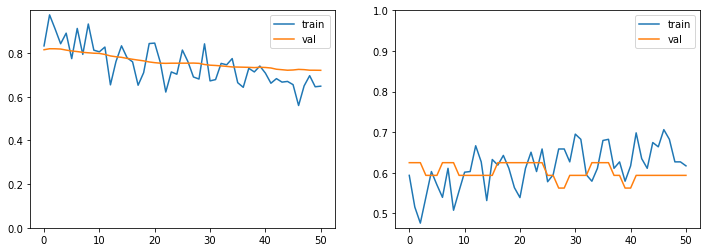

In [38]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 16. Shadows Across Face

158 of 158
141 of 141
(238, 160, 160, 3) float32
(238,) int32
(61, 160, 160, 3) float32
(61,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 257ms/step - loss: 13.2227 - val_loss: 10.1293
Epoch 2/100
100/100 [==============================] - 25s 249ms/step - loss: 8.2662 - val_loss: 8.2170
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 6.2578 - val_loss: 7.5617
Epoch 4/100
100/100 [==============================] - 25s 246ms/step - loss: 5.0471 - val_loss: 7.0140
Epoch 5/100
100/100 [==============================] - 25s 246ms/step - loss: 3.8820 - val_loss: 6.6798
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 3.1522 - val_loss: 6.6467
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 2.7000 - val_loss: 6.4172
Epoch 8/100
100/100 [==============================] - 24s 243ms/step - loss: 2.2279 - val_loss: 6.0272
Epoch 9/100
100/100 [==============================] - 25s 245ms/step - loss: 1.8135 - val_loss: 5.8317
Epoch 10/100
100/100 [==============================] - 25s 24

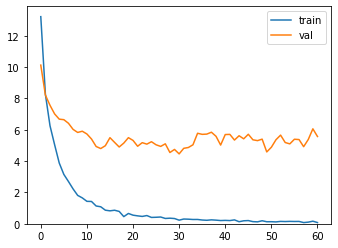

In [39]:
REQ_NAME = 'shadows_across_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 467ms/step - loss: 1.0263 - accuracy: 0.5223 - precision: 0.5837 - recall: 0.1900 - f1: 0.2833 - specificity: 0.8640 - negative_predictive_value: 0.5034 - matthews_correlation_coefficient: 0.0685 - equal_error_rate: 0.5218 - val_loss: 1.0841 - val_accuracy: 0.5156 - val_precision: 0.5833 - val_recall: 0.2341 - val_f1: 0.3036 - val_specificity: 0.8254 - val_negative_predictive_value: 0.5196 - val_matthews_correlation_coefficient: 0.0762 - val_equal_error_rate: 0.6270

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07624, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_07-03_49_57.h5
Epoch 2/100
7/7 [==============================] - 1s 136ms/step - loss: 0.8527 - accuracy: 0.5455 - precision: 0.5360 - recall: 0.3445 - f1: 0.4128 - specificity: 0.7337 - negative_predictive_value: 0.5454 - matthews_correlation_coefficient: 0.0798 - equal_error_rate: 0.4393 - val_loss: 1.0080 - val_ac

7/7 [==============================] - 1s 154ms/step - loss: 0.7192 - accuracy: 0.6000 - precision: 0.6035 - recall: 0.5578 - f1: 0.5698 - specificity: 0.6464 - negative_predictive_value: 0.5991 - matthews_correlation_coefficient: 0.2033 - equal_error_rate: 0.4159 - val_loss: 0.7164 - val_accuracy: 0.6562 - val_precision: 0.7424 - val_recall: 0.4643 - val_f1: 0.5712 - val_specificity: 0.8452 - val_negative_predictive_value: 0.6118 - val_matthews_correlation_coefficient: 0.3310 - val_equal_error_rate: 0.3591

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33100
Epoch 15/100
7/7 [==============================] - 1s 141ms/step - loss: 0.7773 - accuracy: 0.5545 - precision: 0.6102 - recall: 0.4140 - f1: 0.4813 - specificity: 0.7114 - negative_predictive_value: 0.5375 - matthews_correlation_coefficient: 0.1361 - equal_error_rate: 0.4051 - val_loss: 0.7057 - val_accuracy: 0.6719 - val_precision: 0.7591 - val_recall: 0.5000 - val_f1: 0.6020 - val_specificity: 0.8452


Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.48789
Epoch 27/100
7/7 [==============================] - 1s 136ms/step - loss: 0.6351 - accuracy: 0.6773 - precision: 0.7274 - recall: 0.6213 - f1: 0.6663 - specificity: 0.7459 - negative_predictive_value: 0.6386 - matthews_correlation_coefficient: 0.3665 - equal_error_rate: 0.3156 - val_loss: 0.6459 - val_accuracy: 0.7344 - val_precision: 0.8220 - val_recall: 0.5913 - val_f1: 0.6867 - val_specificity: 0.8810 - val_negative_predictive_value: 0.6821 - val_matthews_correlation_coefficient: 0.4879 - val_equal_error_rate: 0.2956

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.48789
Epoch 28/100
7/7 [==============================] - 1s 143ms/step - loss: 0.6729 - accuracy: 0.6591 - precision: 0.6698 - recall: 0.5755 - f1: 0.6181 - specificity: 0.7282 - negative_predictive_value: 0.6397 - matthews_correlation_coefficient: 0.3065 - equal_error_rate: 0.3548 - val_loss: 0.6387 - val_accuracy: 0

7/7 [==============================] - 1s 144ms/step - loss: 0.6260 - accuracy: 0.6773 - precision: 0.6953 - recall: 0.6486 - f1: 0.6551 - specificity: 0.7307 - negative_predictive_value: 0.6781 - matthews_correlation_coefficient: 0.3762 - equal_error_rate: 0.2998 - val_loss: 0.6071 - val_accuracy: 0.7500 - val_precision: 0.8958 - val_recall: 0.5556 - val_f1: 0.6848 - val_specificity: 0.9365 - val_negative_predictive_value: 0.6792 - val_matthews_correlation_coefficient: 0.5311 - val_equal_error_rate: 0.2500

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.53109
Epoch 41/100
7/7 [==============================] - 1s 145ms/step - loss: 0.6492 - accuracy: 0.6741 - precision: 0.7187 - recall: 0.6043 - f1: 0.6488 - specificity: 0.7541 - negative_predictive_value: 0.6399 - matthews_correlation_coefficient: 0.3583 - equal_error_rate: 0.3301 - val_loss: 0.6016 - val_accuracy: 0.7500 - val_precision: 0.8958 - val_recall: 0.5556 - val_f1: 0.6848 - val_specificity: 0.9365


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.53109
Epoch 54/100
7/7 [==============================] - 1s 147ms/step - loss: 0.5473 - accuracy: 0.7364 - precision: 0.7459 - recall: 0.6955 - f1: 0.7126 - specificity: 0.7896 - negative_predictive_value: 0.7280 - matthews_correlation_coefficient: 0.4794 - equal_error_rate: 0.2832 - val_loss: 0.5891 - val_accuracy: 0.7500 - val_precision: 0.8958 - val_recall: 0.5556 - val_f1: 0.6848 - val_specificity: 0.9365 - val_negative_predictive_value: 0.6792 - val_matthews_correlation_coefficient: 0.5311 - val_equal_error_rate: 0.2500

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.53109
Epoch 55/100
7/7 [==============================] - 1s 145ms/step - loss: 0.5527 - accuracy: 0.7318 - precision: 0.7556 - recall: 0.7055 - f1: 0.7238 - specificity: 0.7726 - negative_predictive_value: 0.7103 - matthews_correlation_coefficient: 0.4718 - equal_error_rate: 0.2669 - val_loss: 0.5886 - val_accuracy: 0

7/7 [==============================] - 1s 147ms/step - loss: 0.5896 - accuracy: 0.6727 - precision: 0.7100 - recall: 0.6414 - f1: 0.6683 - specificity: 0.7215 - negative_predictive_value: 0.6449 - matthews_correlation_coefficient: 0.3589 - equal_error_rate: 0.3318 - val_loss: 0.5671 - val_accuracy: 0.7500 - val_precision: 0.8958 - val_recall: 0.5556 - val_f1: 0.6848 - val_specificity: 0.9365 - val_negative_predictive_value: 0.6792 - val_matthews_correlation_coefficient: 0.5311 - val_equal_error_rate: 0.2361

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.53109
Epoch 68/100
7/7 [==============================] - 1s 143ms/step - loss: 0.6126 - accuracy: 0.6818 - precision: 0.6890 - recall: 0.6522 - f1: 0.6618 - specificity: 0.7278 - negative_predictive_value: 0.6809 - matthews_correlation_coefficient: 0.3749 - equal_error_rate: 0.3252 - val_loss: 0.5699 - val_accuracy: 0.7500 - val_precision: 0.8958 - val_recall: 0.5556 - val_f1: 0.6848 - val_specificity: 0.9365


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.53109
Epoch 81/100
7/7 [==============================] - 1s 142ms/step - loss: 0.5238 - accuracy: 0.7545 - precision: 0.7842 - recall: 0.7185 - f1: 0.7467 - specificity: 0.7988 - negative_predictive_value: 0.7223 - matthews_correlation_coefficient: 0.5118 - equal_error_rate: 0.2363 - val_loss: 0.5552 - val_accuracy: 0.7344 - val_precision: 0.8869 - val_recall: 0.5198 - val_f1: 0.6524 - val_specificity: 0.9365 - val_negative_predictive_value: 0.6650 - val_matthews_correlation_coefficient: 0.5003 - val_equal_error_rate: 0.2361

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.53109
Epoch 82/100
7/7 [==============================] - 1s 145ms/step - loss: 0.5052 - accuracy: 0.7682 - precision: 0.7784 - recall: 0.7415 - f1: 0.7500 - specificity: 0.8154 - negative_predictive_value: 0.7653 - matthews_correlation_coefficient: 0.5501 - equal_error_rate: 0.2316 - val_loss: 0.5547 - val_accuracy: 0

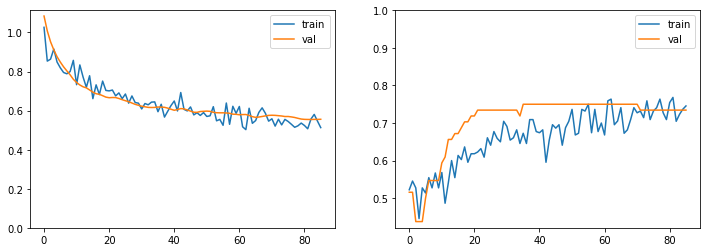

In [40]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 17. Dark Tinted Lenses

315 of 315
136 of 136
(360, 160, 160, 3) float32
(360,) int32
(91, 160, 160, 3) float32
(91,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 257ms/step - loss: 15.6145 - val_loss: 16.6327
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 12.5734 - val_loss: 17.8141
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 9.8904 - val_loss: 19.2620
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 8.8036 - val_loss: 20.3538
Epoch 5/100
100/100 [==============================] - 23s 231ms/step - loss: 7.6191 - val_loss: 21.1522
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 6.6140 - val_loss: 20.0120
Epoch 7/100
100/100 [==============================] - 23s 231ms/step - loss: 5.8455 - val_loss: 20.3052
Epoch 8/100
100/100 [==============================] - 23s 231ms/step - loss: 5.6390 - val_loss: 20.0964
Epoch 9/100
100/100 [==============================] - 23s 234ms/step - loss: 4.9964 - val_loss: 20.1680
Epoch 10/100
100/100 [==============================]

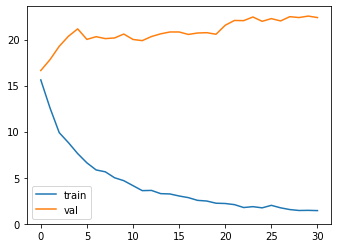

In [41]:
REQ_NAME = 'dark_tinted_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
15/15 [==============================] - 5s 314ms/step - loss: 0.7745 - accuracy: 0.5146 - precision: 0.5263 - recall: 0.3521 - f1: 0.4133 - specificity: 0.6797 - negative_predictive_value: 0.5079 - matthews_correlation_coefficient: 0.0330 - equal_error_rate: 0.5205 - val_loss: 0.7914 - val_accuracy: 0.4271 - val_precision: 0.4528 - val_recall: 0.5931 - val_f1: 0.5122 - val_specificity: 0.2556 - val_negative_predictive_value: 0.3750 - val_matthews_correlation_coefficient: -0.1612 - val_equal_error_rate: 0.5412

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.16121, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_07-04_05_55.h5
Epoch 2/100
15/15 [==============================] - 2s 140ms/step - loss: 0.7428 - accuracy: 0.5254 - precision: 0.5205 - recall: 0.3671 - f1: 0.4194 - specificity: 0.6710 - negative_predictive_value: 0.5276 - matthews_correlation_coefficient: 0.0422 - equal_error_rate: 0.4751 - val_loss: 0.7657 - v


Epoch 00013: val_matthews_correlation_coefficient improved from 0.16233 to 0.26989, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_07-04_05_55.h5
Epoch 14/100
15/15 [==============================] - 2s 143ms/step - loss: 0.7111 - accuracy: 0.5530 - precision: 0.5677 - recall: 0.5408 - f1: 0.5371 - specificity: 0.5862 - negative_predictive_value: 0.5565 - matthews_correlation_coefficient: 0.1255 - equal_error_rate: 0.4555 - val_loss: 0.6691 - val_accuracy: 0.6146 - val_precision: 0.6168 - val_recall: 0.5882 - val_f1: 0.6006 - val_specificity: 0.6389 - val_negative_predictive_value: 0.6117 - val_matthews_correlation_coefficient: 0.2278 - val_equal_error_rate: 0.3643

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.26989
Epoch 15/100
15/15 [==============================] - 2s 140ms/step - loss: 0.6944 - accuracy: 0.5636 - precision: 0.5709 - recall: 0.5161 - f1: 0.5303 - specificity: 0.6199 - negative_predictive_value: 0.5671 - matthew

15/15 [==============================] - 2s 143ms/step - loss: 0.6735 - accuracy: 0.5636 - precision: 0.5806 - recall: 0.5886 - f1: 0.5674 - specificity: 0.5652 - negative_predictive_value: 0.5736 - matthews_correlation_coefficient: 0.1539 - equal_error_rate: 0.4130 - val_loss: 0.6630 - val_accuracy: 0.6458 - val_precision: 0.6889 - val_recall: 0.5074 - val_f1: 0.5784 - val_specificity: 0.7861 - val_negative_predictive_value: 0.6157 - val_matthews_correlation_coefficient: 0.2989 - val_equal_error_rate: 0.3435

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.29893
Epoch 28/100
15/15 [==============================] - 2s 143ms/step - loss: 0.6687 - accuracy: 0.5890 - precision: 0.5948 - recall: 0.5648 - f1: 0.5692 - specificity: 0.6099 - negative_predictive_value: 0.5832 - matthews_correlation_coefficient: 0.1761 - equal_error_rate: 0.4136 - val_loss: 0.6627 - val_accuracy: 0.6458 - val_precision: 0.6889 - val_recall: 0.5074 - val_f1: 0.5784 - val_specificity: 0.

15/15 [==============================] - 2s 142ms/step - loss: 0.6396 - accuracy: 0.6398 - precision: 0.6505 - recall: 0.6241 - f1: 0.6258 - specificity: 0.6715 - negative_predictive_value: 0.6379 - matthews_correlation_coefficient: 0.2919 - equal_error_rate: 0.3635 - val_loss: 0.6644 - val_accuracy: 0.6562 - val_precision: 0.7500 - val_recall: 0.4473 - val_f1: 0.5542 - val_specificity: 0.8708 - val_negative_predictive_value: 0.6091 - val_matthews_correlation_coefficient: 0.3379 - val_equal_error_rate: 0.3435

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.36311
Epoch 41/100
15/15 [==============================] - 2s 145ms/step - loss: 0.6458 - accuracy: 0.5869 - precision: 0.5907 - recall: 0.6040 - f1: 0.5847 - specificity: 0.5803 - negative_predictive_value: 0.5929 - matthews_correlation_coefficient: 0.1838 - equal_error_rate: 0.3866 - val_loss: 0.6641 - val_accuracy: 0.6562 - val_precision: 0.7500 - val_recall: 0.4473 - val_f1: 0.5542 - val_specificity: 0.


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.36311
Epoch 54/100
15/15 [==============================] - 2s 141ms/step - loss: 0.6395 - accuracy: 0.6102 - precision: 0.6147 - recall: 0.6085 - f1: 0.5986 - specificity: 0.6284 - negative_predictive_value: 0.6161 - matthews_correlation_coefficient: 0.2337 - equal_error_rate: 0.3801 - val_loss: 0.6639 - val_accuracy: 0.6458 - val_precision: 0.7361 - val_recall: 0.3664 - val_f1: 0.4782 - val_specificity: 0.9361 - val_negative_predictive_value: 0.5978 - val_matthews_correlation_coefficient: 0.3216 - val_equal_error_rate: 0.3123

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.36311
Epoch 55/100
15/15 [==============================] - 2s 138ms/step - loss: 0.6417 - accuracy: 0.6229 - precision: 0.6486 - recall: 0.5905 - f1: 0.6086 - specificity: 0.6612 - negative_predictive_value: 0.6027 - matthews_correlation_coefficient: 0.2514 - equal_error_rate: 0.3794 - val_loss: 0.6648 - val_accurac

15/15 [==============================] - 2s 140ms/step - loss: 0.6505 - accuracy: 0.6059 - precision: 0.6133 - recall: 0.6036 - f1: 0.5946 - specificity: 0.6279 - negative_predictive_value: 0.6131 - matthews_correlation_coefficient: 0.2289 - equal_error_rate: 0.4102 - val_loss: 0.6710 - val_accuracy: 0.6354 - val_precision: 0.7857 - val_recall: 0.3260 - val_f1: 0.4437 - val_specificity: 0.9569 - val_negative_predictive_value: 0.5852 - val_matthews_correlation_coefficient: 0.3237 - val_equal_error_rate: 0.2810

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.36311
Epoch 68/100
15/15 [==============================] - 2s 141ms/step - loss: 0.6305 - accuracy: 0.6356 - precision: 0.6451 - recall: 0.5969 - f1: 0.6057 - specificity: 0.6839 - negative_predictive_value: 0.6425 - matthews_correlation_coefficient: 0.2839 - equal_error_rate: 0.3615 - val_loss: 0.6726 - val_accuracy: 0.6250 - val_precision: 0.7778 - val_recall: 0.3064 - val_f1: 0.4220 - val_specificity: 0.


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.36311
Epoch 81/100
15/15 [==============================] - 2s 139ms/step - loss: 0.6277 - accuracy: 0.6521 - precision: 0.6766 - recall: 0.6314 - f1: 0.6373 - specificity: 0.6966 - negative_predictive_value: 0.6469 - matthews_correlation_coefficient: 0.3255 - equal_error_rate: 0.3228 - val_loss: 0.6710 - val_accuracy: 0.6250 - val_precision: 0.7778 - val_recall: 0.3064 - val_f1: 0.4220 - val_specificity: 0.9569 - val_negative_predictive_value: 0.5780 - val_matthews_correlation_coefficient: 0.3054 - val_equal_error_rate: 0.3020

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.36311
Epoch 82/100
15/15 [==============================] - 2s 142ms/step - loss: 0.6282 - accuracy: 0.6356 - precision: 0.6176 - recall: 0.6408 - f1: 0.6215 - specificity: 0.6256 - negative_predictive_value: 0.6450 - matthews_correlation_coefficient: 0.2644 - equal_error_rate: 0.3593 - val_loss: 0.6704 - val_accurac

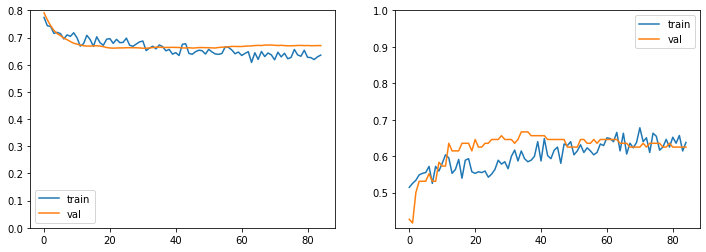

In [42]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 18. Flash Reflection on Lenses

437 of 437
363 of 363
(639, 160, 160, 3) float32
(639,) int32
(161, 160, 160, 3) float32
(161,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 27s 273ms/step - loss: 13.7142 - val_loss: 16.9073
Epoch 2/100
100/100 [==============================] - 25s 247ms/step - loss: 10.9276 - val_loss: 17.6695
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 9.5486 - val_loss: 18.4010
Epoch 4/100
100/100 [==============================] - 25s 245ms/step - loss: 8.5212 - val_loss: 18.8941
Epoch 5/100
100/100 [==============================] - 24s 245ms/step - loss: 7.7673 - val_loss: 20.5375
Epoch 6/100
100/100 [==============================] - 25s 246ms/step - loss: 7.7343 - val_loss: 20.5910
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 6.8645 - val_loss: 21.5639
Epoch 8/100
100/100 [==============================] - 24s 244ms/step - loss: 6.4790 - val_loss: 22.1714
Epoch 9/100
100/100 [==============================] - 25s 246ms/step - loss: 6.1634 - val_loss: 21.7000
Epoch 10/100
100/100 [==============================]

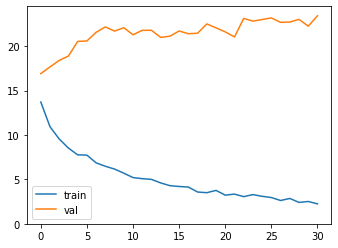

In [43]:
REQ_NAME = 'flash_reflection_on_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
21/21 [==============================] - 6s 278ms/step - loss: 0.8222 - accuracy: 0.4836 - precision: 0.4785 - recall: 0.3243 - f1: 0.3802 - specificity: 0.6318 - negative_predictive_value: 0.4798 - matthews_correlation_coefficient: -0.0425 - equal_error_rate: 0.5362 - val_loss: 0.8301 - val_accuracy: 0.5063 - val_precision: 0.4513 - val_recall: 0.4865 - val_f1: 0.4652 - val_specificity: 0.4925 - val_negative_predictive_value: 0.5210 - val_matthews_correlation_coefficient: -0.0242 - val_equal_error_rate: 0.5377

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.02418, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_07-04_24_46.h5
Epoch 2/100
21/21 [==============================] - 3s 148ms/step - loss: 0.7549 - accuracy: 0.5330 - precision: 0.5278 - recall: 0.4988 - f1: 0.5065 - specificity: 0.5479 - negative_predictive_value: 0.5181 - matthews_correlation_coefficient: 0.0462 - equal_error_rate: 0.4678 - val_loss: 0


Epoch 00012: val_matthews_correlation_coefficient improved from 0.24227 to 0.25239, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_07-04_24_46.h5
Epoch 13/100
21/21 [==============================] - 3s 154ms/step - loss: 0.7092 - accuracy: 0.5556 - precision: 0.5521 - recall: 0.5983 - f1: 0.5667 - specificity: 0.5145 - negative_predictive_value: 0.5555 - matthews_correlation_coefficient: 0.1101 - equal_error_rate: 0.4328 - val_loss: 0.6613 - val_accuracy: 0.6313 - val_precision: 0.6512 - val_recall: 0.5319 - val_f1: 0.5809 - val_specificity: 0.7300 - val_negative_predictive_value: 0.6194 - val_matthews_correlation_coefficient: 0.2660 - val_equal_error_rate: 0.3831

Epoch 00013: val_matthews_correlation_coefficient improved from 0.25239 to 0.26604, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_07-04_24_46.h5
Epoch 14/100
21/21 [==============================] - 3s 150ms/step - loss: 0.7043 - accuracy: 0.5541 - precis


Epoch 00025: val_matthews_correlation_coefficient improved from 0.26645 to 0.28096, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_07-04_24_46.h5
Epoch 26/100
21/21 [==============================] - 3s 146ms/step - loss: 0.6786 - accuracy: 0.5931 - precision: 0.5971 - recall: 0.5940 - f1: 0.5839 - specificity: 0.6071 - negative_predictive_value: 0.5964 - matthews_correlation_coefficient: 0.1970 - equal_error_rate: 0.4093 - val_loss: 0.6306 - val_accuracy: 0.6313 - val_precision: 0.6862 - val_recall: 0.4605 - val_f1: 0.5408 - val_specificity: 0.8058 - val_negative_predictive_value: 0.6113 - val_matthews_correlation_coefficient: 0.2810 - val_equal_error_rate: 0.4131

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.28096
Epoch 27/100
21/21 [==============================] - 3s 150ms/step - loss: 0.6745 - accuracy: 0.5886 - precision: 0.5729 - recall: 0.6238 - f1: 0.5901 - specificity: 0.5596 - negative_predictive_value: 0.6077 -

21/21 [==============================] - 3s 146ms/step - loss: 0.6732 - accuracy: 0.5946 - precision: 0.5960 - recall: 0.6194 - f1: 0.5968 - specificity: 0.5743 - negative_predictive_value: 0.5953 - matthews_correlation_coefficient: 0.1923 - equal_error_rate: 0.3832 - val_loss: 0.6168 - val_accuracy: 0.6125 - val_precision: 0.6683 - val_recall: 0.4071 - val_f1: 0.4966 - val_specificity: 0.8158 - val_negative_predictive_value: 0.5920 - val_matthews_correlation_coefficient: 0.2403 - val_equal_error_rate: 0.4252

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.31102
Epoch 40/100
21/21 [==============================] - 3s 146ms/step - loss: 0.6640 - accuracy: 0.6021 - precision: 0.6038 - recall: 0.6020 - f1: 0.5959 - specificity: 0.6054 - negative_predictive_value: 0.5969 - matthews_correlation_coefficient: 0.2039 - equal_error_rate: 0.3820 - val_loss: 0.6165 - val_accuracy: 0.6125 - val_precision: 0.6683 - val_recall: 0.4071 - val_f1: 0.4966 - val_specificity: 0.


Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.31102
Epoch 53/100
21/21 [==============================] - 3s 145ms/step - loss: 0.6576 - accuracy: 0.6231 - precision: 0.6181 - recall: 0.6211 - f1: 0.6128 - specificity: 0.6265 - negative_predictive_value: 0.6211 - matthews_correlation_coefficient: 0.2432 - equal_error_rate: 0.3696 - val_loss: 0.6095 - val_accuracy: 0.6250 - val_precision: 0.7100 - val_recall: 0.4071 - val_f1: 0.5042 - val_specificity: 0.8408 - val_negative_predictive_value: 0.5990 - val_matthews_correlation_coefficient: 0.2755 - val_equal_error_rate: 0.4190

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.31102
Epoch 54/100
21/21 [==============================] - 3s 146ms/step - loss: 0.6479 - accuracy: 0.6321 - precision: 0.6292 - recall: 0.6105 - f1: 0.6081 - specificity: 0.6669 - negative_predictive_value: 0.6409 - matthews_correlation_coefficient: 0.2735 - equal_error_rate: 0.3795 - val_loss: 0.6087 - val_accurac

21/21 [==============================] - 3s 146ms/step - loss: 0.6537 - accuracy: 0.6051 - precision: 0.6123 - recall: 0.6243 - f1: 0.6081 - specificity: 0.6050 - negative_predictive_value: 0.6075 - matthews_correlation_coefficient: 0.2244 - equal_error_rate: 0.3903 - val_loss: 0.6036 - val_accuracy: 0.6250 - val_precision: 0.7100 - val_recall: 0.4071 - val_f1: 0.5042 - val_specificity: 0.8408 - val_negative_predictive_value: 0.5990 - val_matthews_correlation_coefficient: 0.2755 - val_equal_error_rate: 0.4315

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.31102
Epoch 67/100
21/21 [==============================] - 3s 145ms/step - loss: 0.6550 - accuracy: 0.6042 - precision: 0.6244 - recall: 0.5928 - f1: 0.5948 - specificity: 0.6377 - negative_predictive_value: 0.5983 - matthews_correlation_coefficient: 0.2263 - equal_error_rate: 0.3627 - val_loss: 0.6043 - val_accuracy: 0.6250 - val_precision: 0.7100 - val_recall: 0.4071 - val_f1: 0.5042 - val_specificity: 0.

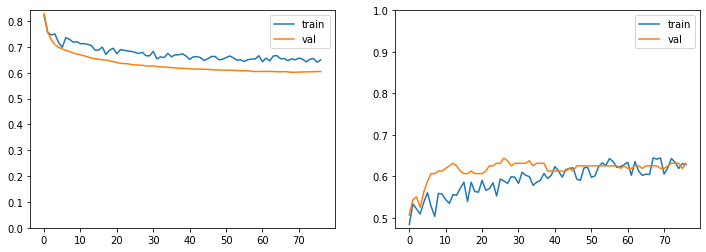

In [44]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### ~~19. Frames Too Heavy~~

#### 20. Frame Covering Eyes  

334 of 334
211 of 211
(435, 160, 160, 3) float32
(435,) int32
(110, 160, 160, 3) float32
(110,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 278ms/step - loss: 18.6576 - val_loss: 16.6262
Epoch 2/100
100/100 [==============================] - 25s 246ms/step - loss: 14.6796 - val_loss: 16.0634
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 12.6444 - val_loss: 16.4169
Epoch 4/100
100/100 [==============================] - 25s 245ms/step - loss: 10.7133 - val_loss: 16.6926
Epoch 5/100
100/100 [==============================] - 25s 245ms/step - loss: 9.6749 - val_loss: 16.7002
Epoch 6/100
100/100 [==============================] - 25s 245ms/step - loss: 9.0444 - val_loss: 17.0109
Epoch 7/100
100/100 [==============================] - 25s 245ms/step - loss: 8.2313 - val_loss: 16.2566
Epoch 8/100
100/100 [==============================] - 25s 245ms/step - loss: 7.6395 - val_loss: 16.5561
Epoch 9/100
100/100 [==============================] - 25s 245ms/step - loss: 7.3860 - val_loss: 16.8131
Epoch 10/100
100/100 [=============================

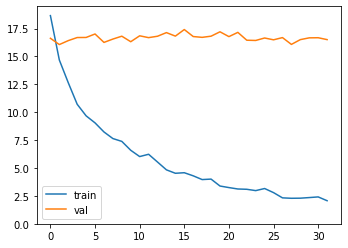

In [45]:
REQ_NAME = 'frame_covering_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
16/16 [==============================] - 6s 359ms/step - loss: 0.7759 - accuracy: 0.4844 - precision: 0.4941 - recall: 0.5495 - f1: 0.5114 - specificity: 0.4298 - negative_predictive_value: 0.4828 - matthews_correlation_coefficient: -0.0218 - equal_error_rate: 0.5001 - val_loss: 0.7032 - val_accuracy: 0.4766 - val_precision: 0.4821 - val_recall: 0.6409 - val_f1: 0.5458 - val_specificity: 0.3071 - val_negative_predictive_value: 0.4596 - val_matthews_correlation_coefficient: -0.0550 - val_equal_error_rate: 0.4603

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.05505, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_07-04_45_03.h5
Epoch 2/100
16/16 [==============================] - 3s 176ms/step - loss: 0.7473 - accuracy: 0.5060 - precision: 0.5026 - recall: 0.5496 - f1: 0.5184 - specificity: 0.4651 - negative_predictive_value: 0.5092 - matthews_correlation_coefficient: 0.0132 - equal_error_rate: 0.5018 - val_loss: 0.6674 -

16/16 [==============================] - 2s 145ms/step - loss: 0.6424 - accuracy: 0.6554 - precision: 0.6747 - recall: 0.6131 - f1: 0.6362 - specificity: 0.7044 - negative_predictive_value: 0.6405 - matthews_correlation_coefficient: 0.3162 - equal_error_rate: 0.3462 - val_loss: 0.5971 - val_accuracy: 0.6484 - val_precision: 0.6672 - val_recall: 0.6343 - val_f1: 0.6358 - val_specificity: 0.6951 - val_negative_predictive_value: 0.6527 - val_matthews_correlation_coefficient: 0.3246 - val_equal_error_rate: 0.3602

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.32459
Epoch 14/100
16/16 [==============================] - 2s 147ms/step - loss: 0.6801 - accuracy: 0.6056 - precision: 0.6158 - recall: 0.5659 - f1: 0.5796 - specificity: 0.6522 - negative_predictive_value: 0.6031 - matthews_correlation_coefficient: 0.2185 - equal_error_rate: 0.3902 - val_loss: 0.5957 - val_accuracy: 0.6484 - val_precision: 0.6672 - val_recall: 0.6343 - val_f1: 0.6358 - val_specificity: 0.

16/16 [==============================] - 2s 145ms/step - loss: 0.6243 - accuracy: 0.6275 - precision: 0.6429 - recall: 0.5680 - f1: 0.5980 - specificity: 0.6967 - negative_predictive_value: 0.6159 - matthews_correlation_coefficient: 0.2616 - equal_error_rate: 0.3538 - val_loss: 0.5920 - val_accuracy: 0.6797 - val_precision: 0.7113 - val_recall: 0.6490 - val_f1: 0.6630 - val_specificity: 0.7431 - val_negative_predictive_value: 0.6757 - val_matthews_correlation_coefficient: 0.3895 - val_equal_error_rate: 0.3049

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.38947
Epoch 27/100
16/16 [==============================] - 2s 147ms/step - loss: 0.6064 - accuracy: 0.6932 - precision: 0.7128 - recall: 0.6757 - f1: 0.6881 - specificity: 0.7190 - negative_predictive_value: 0.6781 - matthews_correlation_coefficient: 0.3927 - equal_error_rate: 0.3024 - val_loss: 0.5916 - val_accuracy: 0.6719 - val_precision: 0.7099 - val_recall: 0.6365 - val_f1: 0.6537 - val_specificity: 0.


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.38947
Epoch 40/100
16/16 [==============================] - 2s 141ms/step - loss: 0.6211 - accuracy: 0.6653 - precision: 0.7070 - recall: 0.5820 - f1: 0.6339 - specificity: 0.7602 - negative_predictive_value: 0.6389 - matthews_correlation_coefficient: 0.3440 - equal_error_rate: 0.3236 - val_loss: 0.5875 - val_accuracy: 0.6797 - val_precision: 0.7183 - val_recall: 0.6157 - val_f1: 0.6518 - val_specificity: 0.7681 - val_negative_predictive_value: 0.6624 - val_matthews_correlation_coefficient: 0.3822 - val_equal_error_rate: 0.3059

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.38947
Epoch 41/100
16/16 [==============================] - 2s 141ms/step - loss: 0.6242 - accuracy: 0.6673 - precision: 0.7141 - recall: 0.5688 - f1: 0.6266 - specificity: 0.7704 - negative_predictive_value: 0.6349 - matthews_correlation_coefficient: 0.3440 - equal_error_rate: 0.3463 - val_loss: 0.5862 - val_accurac

16/16 [==============================] - 2s 140ms/step - loss: 0.6058 - accuracy: 0.6833 - precision: 0.7308 - recall: 0.6051 - f1: 0.6553 - specificity: 0.7776 - negative_predictive_value: 0.6577 - matthews_correlation_coefficient: 0.3855 - equal_error_rate: 0.3286 - val_loss: 0.5872 - val_accuracy: 0.6797 - val_precision: 0.7140 - val_recall: 0.6135 - val_f1: 0.6488 - val_specificity: 0.7681 - val_negative_predictive_value: 0.6633 - val_matthews_correlation_coefficient: 0.3793 - val_equal_error_rate: 0.2902

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.39308
Epoch 54/100
16/16 [==============================] - 2s 147ms/step - loss: 0.6166 - accuracy: 0.6713 - precision: 0.6882 - recall: 0.6372 - f1: 0.6542 - specificity: 0.7161 - negative_predictive_value: 0.6572 - matthews_correlation_coefficient: 0.3492 - equal_error_rate: 0.3202 - val_loss: 0.5861 - val_accuracy: 0.6797 - val_precision: 0.7140 - val_recall: 0.6135 - val_f1: 0.6488 - val_specificity: 0.


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.39308
Epoch 67/100
16/16 [==============================] - 2s 141ms/step - loss: 0.6236 - accuracy: 0.6454 - precision: 0.6608 - recall: 0.5820 - f1: 0.6147 - specificity: 0.7013 - negative_predictive_value: 0.6247 - matthews_correlation_coefficient: 0.2843 - equal_error_rate: 0.3668 - val_loss: 0.5852 - val_accuracy: 0.6797 - val_precision: 0.7140 - val_recall: 0.6135 - val_f1: 0.6488 - val_specificity: 0.7681 - val_negative_predictive_value: 0.6633 - val_matthews_correlation_coefficient: 0.3793 - val_equal_error_rate: 0.2819

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.39308
Epoch 68/100
16/16 [==============================] - 2s 146ms/step - loss: 0.6017 - accuracy: 0.6873 - precision: 0.7098 - recall: 0.6394 - f1: 0.6672 - specificity: 0.7419 - negative_predictive_value: 0.6685 - matthews_correlation_coefficient: 0.3797 - equal_error_rate: 0.2997 - val_loss: 0.5852 - val_accurac

16/16 [==============================] - 2s 143ms/step - loss: 0.5870 - accuracy: 0.6892 - precision: 0.7123 - recall: 0.6238 - f1: 0.6613 - specificity: 0.7518 - negative_predictive_value: 0.6717 - matthews_correlation_coefficient: 0.3796 - equal_error_rate: 0.3091 - val_loss: 0.5801 - val_accuracy: 0.6719 - val_precision: 0.6985 - val_recall: 0.6135 - val_f1: 0.6434 - val_specificity: 0.7473 - val_negative_predictive_value: 0.6576 - val_matthews_correlation_coefficient: 0.3582 - val_equal_error_rate: 0.2902

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.39308
Epoch 81/100
16/16 [==============================] - 2s 143ms/step - loss: 0.6074 - accuracy: 0.6813 - precision: 0.7128 - recall: 0.6292 - f1: 0.6591 - specificity: 0.7493 - negative_predictive_value: 0.6646 - matthews_correlation_coefficient: 0.3779 - equal_error_rate: 0.3106 - val_loss: 0.5806 - val_accuracy: 0.6719 - val_precision: 0.6985 - val_recall: 0.6135 - val_f1: 0.6434 - val_specificity: 0.

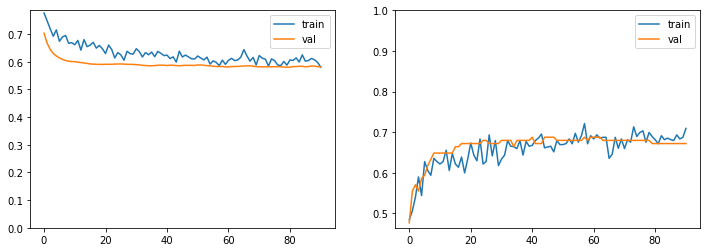

In [46]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 21. Hat/cap 

900 of 900
846 of 846
(1396, 160, 160, 3) float32
(1396,) int32
(350, 160, 160, 3) float32
(350,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 282ms/step - loss: 17.7048 - val_loss: 15.1751
Epoch 2/100
100/100 [==============================] - 25s 245ms/step - loss: 14.9723 - val_loss: 14.4414
Epoch 3/100
100/100 [==============================] - 24s 244ms/step - loss: 13.6437 - val_loss: 12.6425
Epoch 4/100
100/100 [==============================] - 24s 244ms/step - loss: 12.0648 - val_loss: 13.7515
Epoch 5/100
100/100 [==============================] - 24s 244ms/step - loss: 11.5209 - val_loss: 14.1344
Epoch 6/100
100/100 [==============================] - 24s 245ms/step - loss: 10.4954 - val_loss: 11.7833
Epoch 7/100
100/100 [==============================] - 24s 244ms/step - loss: 9.8357 - val_loss: 11.1940
Epoch 8/100
100/100 [==============================] - 24s 244ms/step - loss: 9.3422 - val_loss: 10.7742
Epoch 9/100
100/100 [==============================] - 24s 244ms/step - loss: 8.7681 - val_loss: 11.0504
Epoch 10/100
100/100 [===========================

Epoch 79/100
100/100 [==============================] - 24s 244ms/step - loss: 1.7447 - val_loss: 7.4427
Epoch 80/100
100/100 [==============================] - 24s 244ms/step - loss: 1.7736 - val_loss: 7.4741
Epoch 81/100
100/100 [==============================] - 24s 244ms/step - loss: 1.9034 - val_loss: 7.7132
Epoch 82/100
100/100 [==============================] - 24s 244ms/step - loss: 1.5916 - val_loss: 7.0670
Epoch 83/100
100/100 [==============================] - 24s 244ms/step - loss: 1.8660 - val_loss: 7.1530
Epoch 84/100
100/100 [==============================] - 24s 244ms/step - loss: 1.8765 - val_loss: 7.2802
Epoch 85/100
100/100 [==============================] - 24s 244ms/step - loss: 1.8272 - val_loss: 7.5149
Epoch 86/100
100/100 [==============================] - 24s 245ms/step - loss: 1.5831 - val_loss: 7.4107
Epoch 87/100
100/100 [==============================] - 24s 245ms/step - loss: 1.6438 - val_loss: 6.8060
Epoch 88/100
100/100 [==============================] -

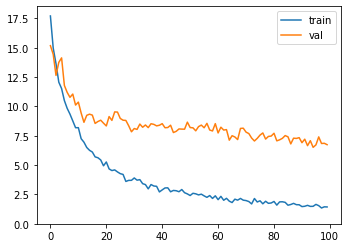

In [47]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
45/45 [==============================] - 10s 227ms/step - loss: 0.8475 - accuracy: 0.5458 - precision: 0.5501 - recall: 0.5445 - f1: 0.5391 - specificity: 0.5484 - negative_predictive_value: 0.5448 - matthews_correlation_coefficient: 0.0938 - equal_error_rate: 0.4671 - val_loss: 0.7641 - val_accuracy: 0.6335 - val_precision: 0.6878 - val_recall: 0.4749 - val_f1: 0.5568 - val_specificity: 0.7909 - val_negative_predictive_value: 0.5991 - val_matthews_correlation_coefficient: 0.2757 - val_equal_error_rate: 0.4283

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27566, saving model to ../../models/siamese_networks/hat_cap_2020_06_07-05_33_43.h5
Epoch 2/100
45/45 [==============================] - 6s 141ms/step - loss: 0.8045 - accuracy: 0.5646 - precision: 0.5720 - recall: 0.5144 - f1: 0.5327 - specificity: 0.6188 - negative_predictive_value: 0.5630 - matthews_correlation_coefficient: 0.1340 - equal_error_rate: 0.4346 - val_loss: 0.7385 - val_accuracy:

45/45 [==============================] - 6s 138ms/step - loss: 0.6460 - accuracy: 0.6285 - precision: 0.6589 - recall: 0.5539 - f1: 0.5931 - specificity: 0.7072 - negative_predictive_value: 0.6120 - matthews_correlation_coefficient: 0.2659 - equal_error_rate: 0.3785 - val_loss: 0.6587 - val_accuracy: 0.6847 - val_precision: 0.8381 - val_recall: 0.4596 - val_f1: 0.5841 - val_specificity: 0.9116 - val_negative_predictive_value: 0.6260 - val_matthews_correlation_coefficient: 0.4124 - val_equal_error_rate: 0.2936

Epoch 00013: val_matthews_correlation_coefficient improved from 0.41060 to 0.41240, saving model to ../../models/siamese_networks/hat_cap_2020_06_07-05_33_43.h5
Epoch 14/100
45/45 [==============================] - 6s 141ms/step - loss: 0.6554 - accuracy: 0.6340 - precision: 0.6721 - recall: 0.5360 - f1: 0.5886 - specificity: 0.7391 - negative_predictive_value: 0.6129 - matthews_correlation_coefficient: 0.2798 - equal_error_rate: 0.3757 - val_loss: 0.6294 - val_accuracy: 0.6932 -


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.48091
Epoch 26/100
45/45 [==============================] - 6s 140ms/step - loss: 0.6192 - accuracy: 0.6597 - precision: 0.6989 - recall: 0.5579 - f1: 0.6153 - specificity: 0.7612 - negative_predictive_value: 0.6328 - matthews_correlation_coefficient: 0.3251 - equal_error_rate: 0.3509 - val_loss: 0.6382 - val_accuracy: 0.7273 - val_precision: 0.8698 - val_recall: 0.5416 - val_f1: 0.6537 - val_specificity: 0.9197 - val_negative_predictive_value: 0.6663 - val_matthews_correlation_coefficient: 0.4940 - val_equal_error_rate: 0.2642

Epoch 00026: val_matthews_correlation_coefficient improved from 0.48091 to 0.49397, saving model to ../../models/siamese_networks/hat_cap_2020_06_07-05_33_43.h5
Epoch 27/100
45/45 [==============================] - 6s 139ms/step - loss: 0.6057 - accuracy: 0.6653 - precision: 0.7074 - recall: 0.5730 - f1: 0.6237 - specificity: 0.7632 - negative_predictive_value: 0.6430 - matthews_correlati


Epoch 00038: val_matthews_correlation_coefficient did not improve from 0.51614
Epoch 39/100
45/45 [==============================] - 6s 139ms/step - loss: 0.5929 - accuracy: 0.6771 - precision: 0.7131 - recall: 0.5934 - f1: 0.6398 - specificity: 0.7675 - negative_predictive_value: 0.6550 - matthews_correlation_coefficient: 0.3643 - equal_error_rate: 0.3256 - val_loss: 0.6262 - val_accuracy: 0.7188 - val_precision: 0.8548 - val_recall: 0.5319 - val_f1: 0.6424 - val_specificity: 0.9052 - val_negative_predictive_value: 0.6592 - val_matthews_correlation_coefficient: 0.4706 - val_equal_error_rate: 0.2613

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.51614
Epoch 40/100
45/45 [==============================] - 6s 142ms/step - loss: 0.5978 - accuracy: 0.6833 - precision: 0.7262 - recall: 0.5936 - f1: 0.6443 - specificity: 0.7765 - negative_predictive_value: 0.6576 - matthews_correlation_coefficient: 0.3766 - equal_error_rate: 0.3267 - val_loss: 0.6285 - val_accurac

45/45 [==============================] - 6s 139ms/step - loss: 0.5879 - accuracy: 0.6785 - precision: 0.7245 - recall: 0.5909 - f1: 0.6434 - specificity: 0.7684 - negative_predictive_value: 0.6505 - matthews_correlation_coefficient: 0.3668 - equal_error_rate: 0.3261 - val_loss: 0.6492 - val_accuracy: 0.7273 - val_precision: 0.9381 - val_recall: 0.4927 - val_f1: 0.6327 - val_specificity: 0.9689 - val_negative_predictive_value: 0.6557 - val_matthews_correlation_coefficient: 0.5200 - val_equal_error_rate: 0.2520

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.52642
Epoch 53/100
45/45 [==============================] - 6s 138ms/step - loss: 0.5848 - accuracy: 0.6938 - precision: 0.7491 - recall: 0.5825 - f1: 0.6470 - specificity: 0.8042 - negative_predictive_value: 0.6612 - matthews_correlation_coefficient: 0.3979 - equal_error_rate: 0.3061 - val_loss: 0.6321 - val_accuracy: 0.7330 - val_precision: 0.8860 - val_recall: 0.5415 - val_f1: 0.6567 - val_specificity: 0.


Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.52642
Epoch 66/100
45/45 [==============================] - 6s 140ms/step - loss: 0.5859 - accuracy: 0.6806 - precision: 0.7152 - recall: 0.6008 - f1: 0.6453 - specificity: 0.7649 - negative_predictive_value: 0.6583 - matthews_correlation_coefficient: 0.3693 - equal_error_rate: 0.3209 - val_loss: 0.6394 - val_accuracy: 0.7301 - val_precision: 0.9076 - val_recall: 0.5226 - val_f1: 0.6499 - val_specificity: 0.9407 - val_negative_predictive_value: 0.6619 - val_matthews_correlation_coefficient: 0.5104 - val_equal_error_rate: 0.2685

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.52642
Epoch 67/100
45/45 [==============================] - 6s 140ms/step - loss: 0.5954 - accuracy: 0.6674 - precision: 0.7076 - recall: 0.5773 - f1: 0.6286 - specificity: 0.7593 - negative_predictive_value: 0.6418 - matthews_correlation_coefficient: 0.3427 - equal_error_rate: 0.3256 - val_loss: 0.6404 - val_accurac

45/45 [==============================] - 6s 140ms/step - loss: 0.5883 - accuracy: 0.6799 - precision: 0.7076 - recall: 0.6038 - f1: 0.6447 - specificity: 0.7584 - negative_predictive_value: 0.6597 - matthews_correlation_coefficient: 0.3646 - equal_error_rate: 0.3206 - val_loss: 0.6461 - val_accuracy: 0.7244 - val_precision: 0.9126 - val_recall: 0.5054 - val_f1: 0.6371 - val_specificity: 0.9483 - val_negative_predictive_value: 0.6562 - val_matthews_correlation_coefficient: 0.5048 - val_equal_error_rate: 0.2801

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.52642
Epoch 80/100
45/45 [==============================] - 6s 140ms/step - loss: 0.5798 - accuracy: 0.6896 - precision: 0.7323 - recall: 0.6099 - f1: 0.6579 - specificity: 0.7754 - negative_predictive_value: 0.6631 - matthews_correlation_coefficient: 0.3901 - equal_error_rate: 0.3141 - val_loss: 0.6298 - val_accuracy: 0.7301 - val_precision: 0.8762 - val_recall: 0.5506 - val_f1: 0.6594 - val_specificity: 0.


Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.52642
Epoch 93/100
45/45 [==============================] - 6s 140ms/step - loss: 0.5714 - accuracy: 0.6986 - precision: 0.7411 - recall: 0.6100 - f1: 0.6630 - specificity: 0.7857 - negative_predictive_value: 0.6681 - matthews_correlation_coefficient: 0.4021 - equal_error_rate: 0.3113 - val_loss: 0.6292 - val_accuracy: 0.7301 - val_precision: 0.8850 - val_recall: 0.5381 - val_f1: 0.6547 - val_specificity: 0.9251 - val_negative_predictive_value: 0.6659 - val_matthews_correlation_coefficient: 0.5016 - val_equal_error_rate: 0.2636

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.52642
Epoch 94/100
45/45 [==============================] - 6s 141ms/step - loss: 0.5808 - accuracy: 0.6958 - precision: 0.7276 - recall: 0.6208 - f1: 0.6650 - specificity: 0.7743 - negative_predictive_value: 0.6705 - matthews_correlation_coefficient: 0.3965 - equal_error_rate: 0.3097 - val_loss: 0.6376 - val_accurac

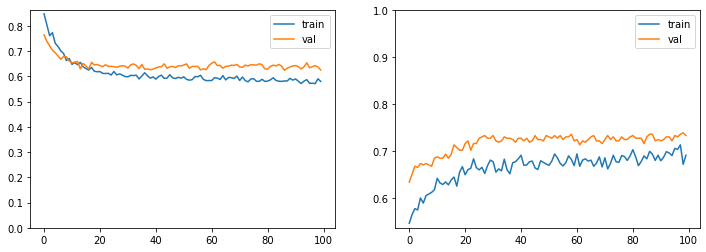

In [48]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *22. Veil Over Face*

354 of 354
354 of 354
(566, 160, 160, 3) float32
(566,) int32
(142, 160, 160, 3) float32
(142,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 284ms/step - loss: 8.0464 - val_loss: 10.5619
Epoch 2/100
100/100 [==============================] - 25s 249ms/step - loss: 3.6945 - val_loss: 12.8995
Epoch 3/100
100/100 [==============================] - 25s 250ms/step - loss: 2.3556 - val_loss: 13.9554
Epoch 4/100
100/100 [==============================] - 25s 250ms/step - loss: 1.6995 - val_loss: 14.3774
Epoch 5/100
100/100 [==============================] - 25s 249ms/step - loss: 1.2279 - val_loss: 15.1682
Epoch 6/100
100/100 [==============================] - 25s 249ms/step - loss: 1.1127 - val_loss: 15.5424
Epoch 7/100
100/100 [==============================] - 25s 250ms/step - loss: 0.8552 - val_loss: 14.6031
Epoch 8/100
100/100 [==============================] - 25s 250ms/step - loss: 0.6311 - val_loss: 14.9946
Epoch 9/100
100/100 [==============================] - 25s 249ms/step - loss: 0.6238 - val_loss: 15.3563
Epoch 10/100
100/100 [==============================] -

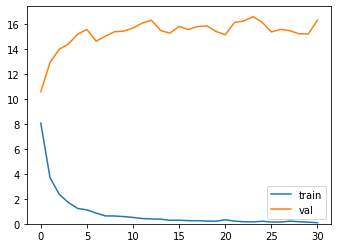

In [49]:
REQ_NAME = 'veil_over_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
17/17 [==============================] - 6s 378ms/step - loss: 0.7818 - accuracy: 0.4890 - precision: 0.4856 - recall: 0.4075 - f1: 0.4388 - specificity: 0.5640 - negative_predictive_value: 0.4894 - matthews_correlation_coefficient: -0.0268 - equal_error_rate: 0.5112 - val_loss: 0.7426 - val_accuracy: 0.3672 - val_precision: 0.4230 - val_recall: 0.5701 - val_f1: 0.4815 - val_specificity: 0.1511 - val_negative_predictive_value: 0.2370 - val_matthews_correlation_coefficient: -0.3070 - val_equal_error_rate: 0.6472

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.30696, saving model to ../../models/siamese_networks/veil_over_face_2020_06_07-06_00_42.h5
Epoch 2/100
17/17 [==============================] - 3s 149ms/step - loss: 0.7390 - accuracy: 0.5225 - precision: 0.5355 - recall: 0.4723 - f1: 0.4946 - specificity: 0.5826 - negative_predictive_value: 0.5160 - matthews_correlation_coefficient: 0.0532 - equal_error_rate: 0.4741 - val_loss: 0.7198 - val_


Epoch 00012: val_matthews_correlation_coefficient improved from 0.51196 to 0.51271, saving model to ../../models/siamese_networks/veil_over_face_2020_06_07-06_00_42.h5
Epoch 13/100
17/17 [==============================] - 3s 147ms/step - loss: 0.6182 - accuracy: 0.6648 - precision: 0.6871 - recall: 0.6508 - f1: 0.6568 - specificity: 0.6959 - negative_predictive_value: 0.6625 - matthews_correlation_coefficient: 0.3481 - equal_error_rate: 0.3285 - val_loss: 0.5856 - val_accuracy: 0.7500 - val_precision: 0.8876 - val_recall: 0.5956 - val_f1: 0.7127 - val_specificity: 0.9181 - val_negative_predictive_value: 0.6730 - val_matthews_correlation_coefficient: 0.5365 - val_equal_error_rate: 0.2336

Epoch 00013: val_matthews_correlation_coefficient improved from 0.51271 to 0.53646, saving model to ../../models/siamese_networks/veil_over_face_2020_06_07-06_00_42.h5
Epoch 14/100
17/17 [==============================] - 3s 148ms/step - loss: 0.6365 - accuracy: 0.6479 - precision: 0.6499 - recall: 0.


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.58420
Epoch 26/100
17/17 [==============================] - 2s 141ms/step - loss: 0.5669 - accuracy: 0.7135 - precision: 0.7306 - recall: 0.6838 - f1: 0.6979 - specificity: 0.7534 - negative_predictive_value: 0.7098 - matthews_correlation_coefficient: 0.4387 - equal_error_rate: 0.3002 - val_loss: 0.5391 - val_accuracy: 0.7422 - val_precision: 0.9068 - val_recall: 0.5712 - val_f1: 0.7000 - val_specificity: 0.9329 - val_negative_predictive_value: 0.6618 - val_matthews_correlation_coefficient: 0.5353 - val_equal_error_rate: 0.1951

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.58420
Epoch 27/100
17/17 [==============================] - 3s 149ms/step - loss: 0.5418 - accuracy: 0.7453 - precision: 0.7334 - recall: 0.7830 - f1: 0.7509 - specificity: 0.7204 - negative_predictive_value: 0.7659 - matthews_correlation_coefficient: 0.5012 - equal_error_rate: 0.2432 - val_loss: 0.5384 - val_accurac

17/17 [==============================] - 2s 141ms/step - loss: 0.5354 - accuracy: 0.7603 - precision: 0.7605 - recall: 0.7628 - f1: 0.7546 - specificity: 0.7684 - negative_predictive_value: 0.7656 - matthews_correlation_coefficient: 0.5286 - equal_error_rate: 0.2501 - val_loss: 0.5272 - val_accuracy: 0.7500 - val_precision: 0.9273 - val_recall: 0.5703 - val_f1: 0.7057 - val_specificity: 0.9495 - val_negative_predictive_value: 0.6656 - val_matthews_correlation_coefficient: 0.5551 - val_equal_error_rate: 0.1795

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.58420
Epoch 40/100
17/17 [==============================] - 2s 137ms/step - loss: 0.5074 - accuracy: 0.7809 - precision: 0.8285 - recall: 0.7244 - f1: 0.7664 - specificity: 0.8423 - negative_predictive_value: 0.7469 - matthews_correlation_coefficient: 0.5706 - equal_error_rate: 0.2246 - val_loss: 0.5267 - val_accuracy: 0.7500 - val_precision: 0.9273 - val_recall: 0.5703 - val_f1: 0.7057 - val_specificity: 0.


Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.58420
Epoch 53/100
17/17 [==============================] - 2s 138ms/step - loss: 0.5396 - accuracy: 0.7341 - precision: 0.7655 - recall: 0.7115 - f1: 0.7286 - specificity: 0.7666 - negative_predictive_value: 0.7165 - matthews_correlation_coefficient: 0.4799 - equal_error_rate: 0.2604 - val_loss: 0.5407 - val_accuracy: 0.7344 - val_precision: 0.9273 - val_recall: 0.5370 - val_f1: 0.6796 - val_specificity: 0.9495 - val_negative_predictive_value: 0.6495 - val_matthews_correlation_coefficient: 0.5293 - val_equal_error_rate: 0.1795

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.58420
Epoch 54/100
17/17 [==============================] - 2s 139ms/step - loss: 0.5204 - accuracy: 0.7491 - precision: 0.7690 - recall: 0.7309 - f1: 0.7420 - specificity: 0.7838 - negative_predictive_value: 0.7402 - matthews_correlation_coefficient: 0.5119 - equal_error_rate: 0.2272 - val_loss: 0.5459 - val_accurac

17/17 [==============================] - 2s 136ms/step - loss: 0.4824 - accuracy: 0.7846 - precision: 0.7984 - recall: 0.7811 - f1: 0.7811 - specificity: 0.8088 - negative_predictive_value: 0.7850 - matthews_correlation_coefficient: 0.5866 - equal_error_rate: 0.2119 - val_loss: 0.5493 - val_accuracy: 0.7266 - val_precision: 0.9217 - val_recall: 0.5213 - val_f1: 0.6658 - val_specificity: 0.9495 - val_negative_predictive_value: 0.6426 - val_matthews_correlation_coefficient: 0.5150 - val_equal_error_rate: 0.1795

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.58420
Epoch 67/100
17/17 [==============================] - 2s 140ms/step - loss: 0.5082 - accuracy: 0.7790 - precision: 0.8139 - recall: 0.7336 - f1: 0.7649 - specificity: 0.8336 - negative_predictive_value: 0.7527 - matthews_correlation_coefficient: 0.5667 - equal_error_rate: 0.2123 - val_loss: 0.5525 - val_accuracy: 0.7266 - val_precision: 0.9217 - val_recall: 0.5213 - val_f1: 0.6658 - val_specificity: 0.

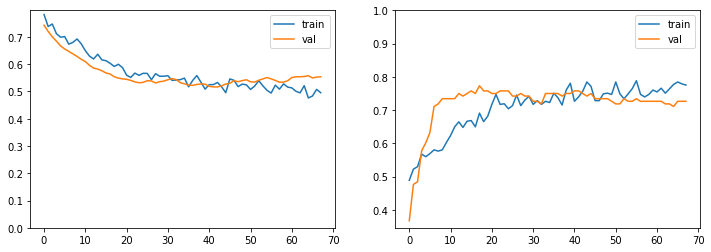

In [50]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 23. Mouth Open 

452 of 452
420 of 420
(697, 160, 160, 3) float32
(697,) int32
(175, 160, 160, 3) float32
(175,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 29s 286ms/step - loss: 16.2464 - val_loss: 20.8429
Epoch 2/100
100/100 [==============================] - 25s 246ms/step - loss: 12.5384 - val_loss: 25.8532
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 11.5305 - val_loss: 28.8785
Epoch 4/100
100/100 [==============================] - 25s 248ms/step - loss: 9.9178 - val_loss: 28.7029
Epoch 5/100
100/100 [==============================] - 25s 247ms/step - loss: 9.5321 - val_loss: 30.9972
Epoch 6/100
100/100 [==============================] - 25s 246ms/step - loss: 8.3696 - val_loss: 32.4869
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 7.7899 - val_loss: 32.5595
Epoch 8/100
100/100 [==============================] - 25s 247ms/step - loss: 7.2581 - val_loss: 32.6937
Epoch 9/100
100/100 [==============================] - 25s 246ms/step - loss: 6.0791 - val_loss: 31.9576
Epoch 10/100
100/100 [==============================

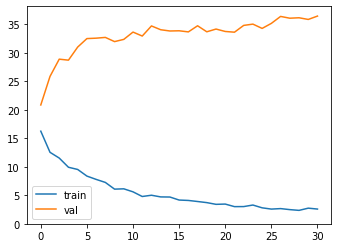

In [51]:
REQ_NAME = 'mouth_open'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
22/22 [==============================] - 7s 329ms/step - loss: 0.7498 - accuracy: 0.5142 - precision: 0.5107 - recall: 0.4613 - f1: 0.4804 - specificity: 0.5585 - negative_predictive_value: 0.5116 - matthews_correlation_coefficient: 0.0209 - equal_error_rate: 0.4949 - val_loss: 0.6883 - val_accuracy: 0.5000 - val_precision: 0.4946 - val_recall: 0.5141 - val_f1: 0.5013 - val_specificity: 0.4905 - val_negative_predictive_value: 0.5089 - val_matthews_correlation_coefficient: 0.0041 - val_equal_error_rate: 0.4820

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00410, saving model to ../../models/siamese_networks/mouth_open_2020_06_07-06_20_20.h5
Epoch 2/100
22/22 [==============================] - 4s 163ms/step - loss: 0.7638 - accuracy: 0.5145 - precision: 0.5179 - recall: 0.5068 - f1: 0.5038 - specificity: 0.5292 - negative_predictive_value: 0.5184 - matthews_correlation_coefficient: 0.0361 - equal_error_rate: 0.4861 - val_loss: 0.6889 - val_accurac


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.30058
Epoch 14/100
22/22 [==============================] - 3s 153ms/step - loss: 0.6859 - accuracy: 0.5797 - precision: 0.5707 - recall: 0.6413 - f1: 0.5989 - specificity: 0.5202 - negative_predictive_value: 0.5925 - matthews_correlation_coefficient: 0.1623 - equal_error_rate: 0.4181 - val_loss: 0.7228 - val_accuracy: 0.6313 - val_precision: 0.6122 - val_recall: 0.6974 - val_f1: 0.6466 - val_specificity: 0.5750 - val_negative_predictive_value: 0.6656 - val_matthews_correlation_coefficient: 0.2750 - val_equal_error_rate: 0.3567

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.30058
Epoch 15/100
22/22 [==============================] - 3s 152ms/step - loss: 0.7005 - accuracy: 0.5884 - precision: 0.5980 - recall: 0.5966 - f1: 0.5886 - specificity: 0.5924 - negative_predictive_value: 0.5891 - matthews_correlation_coefficient: 0.1880 - equal_error_rate: 0.4091 - val_loss: 0.7231 - val_accurac

22/22 [==============================] - 3s 151ms/step - loss: 0.6626 - accuracy: 0.6043 - precision: 0.6106 - recall: 0.6067 - f1: 0.6012 - specificity: 0.6108 - negative_predictive_value: 0.6057 - matthews_correlation_coefficient: 0.2169 - equal_error_rate: 0.3900 - val_loss: 0.7129 - val_accuracy: 0.6625 - val_precision: 0.6494 - val_recall: 0.6683 - val_f1: 0.6560 - val_specificity: 0.6597 - val_negative_predictive_value: 0.6803 - val_matthews_correlation_coefficient: 0.3288 - val_equal_error_rate: 0.3509

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.34845
Epoch 28/100
22/22 [==============================] - 3s 152ms/step - loss: 0.6703 - accuracy: 0.5826 - precision: 0.5854 - recall: 0.6076 - f1: 0.5918 - specificity: 0.5656 - negative_predictive_value: 0.5851 - matthews_correlation_coefficient: 0.1718 - equal_error_rate: 0.4175 - val_loss: 0.7117 - val_accuracy: 0.6562 - val_precision: 0.6417 - val_recall: 0.6683 - val_f1: 0.6528 - val_specificity: 0.


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.34845
Epoch 41/100
22/22 [==============================] - 3s 149ms/step - loss: 0.6476 - accuracy: 0.6217 - precision: 0.6286 - recall: 0.6162 - f1: 0.6150 - specificity: 0.6337 - negative_predictive_value: 0.6201 - matthews_correlation_coefficient: 0.2492 - equal_error_rate: 0.3694 - val_loss: 0.7130 - val_accuracy: 0.6562 - val_precision: 0.6460 - val_recall: 0.6550 - val_f1: 0.6488 - val_specificity: 0.6581 - val_negative_predictive_value: 0.6689 - val_matthews_correlation_coefficient: 0.3140 - val_equal_error_rate: 0.3383

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.34845
Epoch 42/100
22/22 [==============================] - 3s 155ms/step - loss: 0.6695 - accuracy: 0.6014 - precision: 0.6009 - recall: 0.6213 - f1: 0.6059 - specificity: 0.5875 - negative_predictive_value: 0.6038 - matthews_correlation_coefficient: 0.2067 - equal_error_rate: 0.3813 - val_loss: 0.7152 - val_accurac

22/22 [==============================] - 3s 148ms/step - loss: 0.6237 - accuracy: 0.6623 - precision: 0.6667 - recall: 0.6633 - f1: 0.6595 - specificity: 0.6682 - negative_predictive_value: 0.6597 - matthews_correlation_coefficient: 0.3289 - equal_error_rate: 0.3369 - val_loss: 0.7180 - val_accuracy: 0.6438 - val_precision: 0.6489 - val_recall: 0.6025 - val_f1: 0.6226 - val_specificity: 0.6817 - val_negative_predictive_value: 0.6421 - val_matthews_correlation_coefficient: 0.2875 - val_equal_error_rate: 0.3383

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 55/100
22/22 [==============================] - 3s 148ms/step - loss: 0.6479 - accuracy: 0.6435 - precision: 0.6617 - recall: 0.6322 - f1: 0.6397 - specificity: 0.6652 - negative_predictive_value: 0.6347 - matthews_correlation_coefficient: 0.2969 - equal_error_rate: 0.3663 - val_loss: 0.7189 - val_accuracy: 0.6438 - val_precision: 0.6489 - val_recall: 0.6025 - val_f1: 0.6226 - val_specificity: 0.


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 68/100
22/22 [==============================] - 3s 150ms/step - loss: 0.6371 - accuracy: 0.6362 - precision: 0.6416 - recall: 0.6303 - f1: 0.6293 - specificity: 0.6464 - negative_predictive_value: 0.6328 - matthews_correlation_coefficient: 0.2755 - equal_error_rate: 0.3739 - val_loss: 0.7072 - val_accuracy: 0.6500 - val_precision: 0.6626 - val_recall: 0.6033 - val_f1: 0.6296 - val_specificity: 0.6934 - val_negative_predictive_value: 0.6423 - val_matthews_correlation_coefficient: 0.3008 - val_equal_error_rate: 0.3383

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 69/100
22/22 [==============================] - 3s 149ms/step - loss: 0.6527 - accuracy: 0.6130 - precision: 0.6331 - recall: 0.6016 - f1: 0.6088 - specificity: 0.6399 - negative_predictive_value: 0.6059 - matthews_correlation_coefficient: 0.2402 - equal_error_rate: 0.3937 - val_loss: 0.7069 - val_accurac

22/22 [==============================] - 3s 150ms/step - loss: 0.6342 - accuracy: 0.6362 - precision: 0.6377 - recall: 0.6210 - f1: 0.6208 - specificity: 0.6528 - negative_predictive_value: 0.6362 - matthews_correlation_coefficient: 0.2738 - equal_error_rate: 0.3670 - val_loss: 0.7072 - val_accuracy: 0.6438 - val_precision: 0.6546 - val_recall: 0.5891 - val_f1: 0.6166 - val_specificity: 0.6934 - val_negative_predictive_value: 0.6391 - val_matthews_correlation_coefficient: 0.2880 - val_equal_error_rate: 0.3383

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 82/100
22/22 [==============================] - 3s 146ms/step - loss: 0.6476 - accuracy: 0.6159 - precision: 0.6234 - recall: 0.6027 - f1: 0.6076 - specificity: 0.6360 - negative_predictive_value: 0.6117 - matthews_correlation_coefficient: 0.2368 - equal_error_rate: 0.3685 - val_loss: 0.7092 - val_accuracy: 0.6375 - val_precision: 0.6529 - val_recall: 0.5766 - val_f1: 0.6093 - val_specificity: 0.


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 95/100
22/22 [==============================] - 4s 162ms/step - loss: 0.6435 - accuracy: 0.6406 - precision: 0.6499 - recall: 0.6176 - f1: 0.6275 - specificity: 0.6621 - negative_predictive_value: 0.6263 - matthews_correlation_coefficient: 0.2779 - equal_error_rate: 0.3509 - val_loss: 0.7068 - val_accuracy: 0.6500 - val_precision: 0.6644 - val_recall: 0.5782 - val_f1: 0.6162 - val_specificity: 0.7185 - val_negative_predictive_value: 0.6419 - val_matthews_correlation_coefficient: 0.3014 - val_equal_error_rate: 0.3509

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 96/100
22/22 [==============================] - 3s 152ms/step - loss: 0.6326 - accuracy: 0.6580 - precision: 0.6801 - recall: 0.6208 - f1: 0.6434 - specificity: 0.7056 - negative_predictive_value: 0.6447 - matthews_correlation_coefficient: 0.3255 - equal_error_rate: 0.3513 - val_loss: 0.7065 - val_accurac

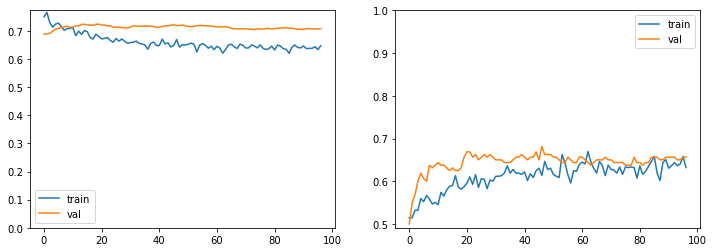

In [52]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *24. Presence of Other Faces or Toys too Close to Face*

64 of 64
18 of 18
(65, 160, 160, 3) float32
(65,) int32
(17, 160, 160, 3) float32
(17,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 168ms/step - loss: 15.0168 - val_loss: 29.6860
Epoch 2/100
100/100 [==============================] - 13s 126ms/step - loss: 8.6412 - val_loss: 29.5389
Epoch 3/100
100/100 [==============================] - 13s 126ms/step - loss: 5.4295 - val_loss: 27.3659
Epoch 4/100
100/100 [==============================] - 13s 126ms/step - loss: 3.3128 - val_loss: 27.9903
Epoch 5/100
100/100 [==============================] - 13s 126ms/step - loss: 2.4379 - val_loss: 29.6839
Epoch 6/100
100/100 [==============================] - 13s 127ms/step - loss: 1.7570 - val_loss: 25.7494
Epoch 7/100
100/100 [==============================] - 13s 126ms/step - loss: 1.4077 - val_loss: 30.4246
Epoch 8/100
100/100 [==============================] - 13s 127ms/step - loss: 1.1559 - val_loss: 27.0173
Epoch 9/100
100/100 [==============================] - 13s 126ms/step - loss: 0.9846 - val_loss: 29.7147
Epoch 10/100
100/100 [==============================] 

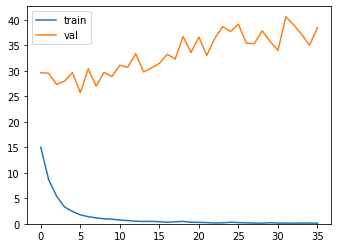

In [53]:
REQ_NAME = 'presence_of_other_faces_or_toys'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 0.7605 - accuracy: 0.5312 - precision: 0.4960 - recall: 0.4010 - f1: 0.4393 - specificity: 0.6475 - negative_predictive_value: 0.5532 - matthews_correlation_coefficient: 0.0488 - equal_error_rate: 0.5017 - val_loss: 0.6279 - val_accuracy: 0.5882 - val_precision: 0.4545 - val_recall: 0.8333 - val_f1: 0.5882 - val_specificity: 0.4545 - val_negative_predictive_value: 0.8333 - val_matthews_correlation_coefficient: 0.2879 - val_equal_error_rate: 0.0833

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28788, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_07-06_37_01.h5
Epoch 2/100
3/3 [==============================] - 0s 155ms/step - loss: 0.7018 - accuracy: 0.5714 - precision: 0.7278 - recall: 0.4569 - f1: 0.5333 - specificity: 0.4449 - negative_predictive_value: 0.3990 - matthews_correlation_coefficient: 0.1254 - equal_error_rate: 0.2887 - val_loss: 0.6220

3/3 [==============================] - 0s 148ms/step - loss: 0.6955 - accuracy: 0.6143 - precision: 0.7374 - recall: 0.5694 - f1: 0.6370 - specificity: 0.4645 - negative_predictive_value: 0.4099 - matthews_correlation_coefficient: 0.1461 - equal_error_rate: 0.2886 - val_loss: 0.5749 - val_accuracy: 0.6471 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.6364 - val_negative_predictive_value: 0.7778 - val_matthews_correlation_coefficient: 0.2901 - val_equal_error_rate: 0.1667

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.44970
Epoch 15/100
3/3 [==============================] - 0s 146ms/step - loss: 0.6762 - accuracy: 0.5857 - precision: 0.6929 - recall: 0.5460 - f1: 0.6044 - specificity: 0.4390 - negative_predictive_value: 0.4062 - matthews_correlation_coefficient: 0.0976 - equal_error_rate: 0.2895 - val_loss: 0.5734 - val_accuracy: 0.6471 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.6364


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.44970
Epoch 28/100
3/3 [==============================] - 0s 138ms/step - loss: 0.7501 - accuracy: 0.6143 - precision: 0.7607 - recall: 0.4683 - f1: 0.5547 - specificity: 0.4907 - negative_predictive_value: 0.4281 - matthews_correlation_coefficient: 0.1849 - equal_error_rate: 0.2890 - val_loss: 0.5651 - val_accuracy: 0.6471 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.6364 - val_negative_predictive_value: 0.7778 - val_matthews_correlation_coefficient: 0.2901 - val_equal_error_rate: 0.1667

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.44970
Epoch 29/100
3/3 [==============================] - 0s 158ms/step - loss: 0.6872 - accuracy: 0.6146 - precision: 0.6143 - recall: 0.5335 - f1: 0.5644 - specificity: 0.6889 - negative_predictive_value: 0.6242 - matthews_correlation_coefficient: 0.2301 - equal_error_rate: 0.4392 - val_loss: 0.5647 - val_accuracy: 0

3/3 [==============================] - 1s 167ms/step - loss: 0.6663 - accuracy: 0.6562 - precision: 0.6377 - recall: 0.6286 - f1: 0.6308 - specificity: 0.6831 - negative_predictive_value: 0.6754 - matthews_correlation_coefficient: 0.3124 - equal_error_rate: 0.3664 - val_loss: 0.5542 - val_accuracy: 0.6471 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.6364 - val_negative_predictive_value: 0.7778 - val_matthews_correlation_coefficient: 0.2901 - val_equal_error_rate: 0.1667

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.44970
Epoch 42/100
3/3 [==============================] - 0s 156ms/step - loss: 0.6817 - accuracy: 0.5286 - precision: 0.6789 - recall: 0.5306 - f1: 0.5764 - specificity: 0.3456 - negative_predictive_value: 0.3639 - matthews_correlation_coefficient: 0.0428 - equal_error_rate: 0.3403 - val_loss: 0.5535 - val_accuracy: 0.6471 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.6364

Restoring model weights from the end of the best epoch

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.44970
Epoch 00054: early stopping

   Final Accuracy:  64.71%
  Final Precision:  88.89%
     Final Recall:  61.54%
  Final F-measure:  72.73%
Final Specificity:  75.00%
        Final NPV:  37.50%
        Final MCC:  31.05%

[[3 1]
 [5 8]]
              precision    recall  f1-score   support

           0       0.38      0.75      0.50         4
           1       0.89      0.62      0.73        13

    accuracy                           0.65        17
   macro avg       0.63      0.68      0.61        17
weighted avg       0.77      0.65      0.67        17



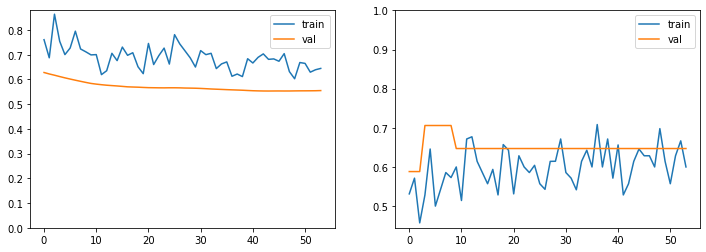

In [54]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

In [55]:
print(len(list_model_files))
print(np.array(list_model_files))

21
['../../models/siamese_networks/blurred_2020_06_06-23_38_13.h5'
 '../../models/siamese_networks/looking_away_2020_06_06-23_51_32.h5'
 '../../models/siamese_networks/unnatural_skin_tone_2020_06_07-00_01_41.h5'
 '../../models/siamese_networks/too_dark_light_2020_06_07-00_32_34.h5'
 '../../models/siamese_networks/washed_out_2020_06_07-00_42_57.h5'
 '../../models/siamese_networks/pixelation_2020_06_07-00_54_03.h5'
 '../../models/siamese_networks/hair_across_eyes_2020_06_07-01_36_01.h5'
 '../../models/siamese_networks/eyes_closed_2020_06_07-01_49_25.h5'
 '../../models/siamese_networks/varied_background_2020_06_07-02_07_09.h5'
 '../../models/siamese_networks/roll_pitch_yaw_2020_06_07-02_21_47.h5'
 '../../models/siamese_networks/flash_reflection_on_skin_2020_06_07-02_34_48.h5'
 '../../models/siamese_networks/red_eyes_2020_06_07-02_46_06.h5'
 '../../models/siamese_networks/shadows_behind_head_2020_06_07-03_22_10.h5'
 '../../models/siamese_networks/shadows_across_face_2020_06_07-03_49_57.h5'

# Models Merge

In [56]:
def load_shared_model(file_autoencoder):
    autoencoder = load_model(file_autoencoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    embeddings = GlobalAvgPool2D(name='embeddings')(encoder_output)
    shared_model = Model(inputs=autoencoder.inputs, outputs=embeddings)
    return shared_model


def add_requirement_branch_to_base_model(base_model, req_model):
    n_layers = len(base_model.layers)
    req_layers = [layer for layer in req_model.layers[n_layers:]]

    outputs = base_model.output
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)
    return outputs

In [57]:
shared_model = load_shared_model(FILE_BASE_MODEL)
shared_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256

In [58]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in list_model_files]
list_outputs = [add_requirement_branch_to_base_model(shared_model, req_model) for req_model in list_models]

In [62]:
FILE_MERGED_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix='merged_model_')
print(FILE_MERGED_MODEL)

merged_model = Model(inputs=shared_model.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

../../models/siamese_networks/merged_model_2020_06_07-10_47_04.h5
Model: "model_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
_________________________

In [63]:
import cv2
from glob import glob

list_files = ['../../data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../../data/cropped_faces/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.5573133]], dtype=float32),
 array([[0.51872575]], dtype=float32),
 array([[0.81869876]], dtype=float32),
 array([[0.19192545]], dtype=float32),
 array([[0.44231698]], dtype=float32),
 array([[0.6706011]], dtype=float32),
 array([[0.5043935]], dtype=float32),
 array([[0.40181082]], dtype=float32),
 array([[0.41918665]], dtype=float32),
 array([[0.6370824]], dtype=float32),
 array([[0.42976198]], dtype=float32),
 array([[0.5211322]], dtype=float32),
 array([[0.40263155]], dtype=float32),
 array([[0.43380105]], dtype=float32),
 array([[0.732342]], dtype=float32),
 array([[0.4768576]], dtype=float32),
 array([[0.6907729]], dtype=float32),
 array([[0.8107505]], dtype=float32),
 array([[0.6212543]], dtype=float32),
 array([[0.41954383]], dtype=float32),
 array([[0.64807105]], dtype=float32)]